## Development of a score based on the gaussian heatmaps 
This can be used to generate the 'ground truth' score of the heatmaps produced from the Contextual layer , which will be compared with the score produced from the FCN heatmaps layer. 

- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
import tensorflow          as tf
import keras.backend       as KB
import numpy               as np
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.visualize       import display_gt_bboxes, display_roi_proposals, plot_3d_heatmap 
from mrcnn.visualize       import display_gt_bboxes, display_roi_proposals
import mrcnn.visualize     as visualize
from mrcnn.prep_notebook   import mrcnn_coco_train, fcn_coco_train, prep_coco_dataset
# from mrcnn.prep_notebook   import prep_oldshapes_dev
from mrcnn.coco            import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
import mrcnn.model_mrcnn   as mrcnn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)


mrcnn_model, mrcnn_config = mrcnn_coco_train(mode = 'trainfcn')
dataset_val, val_generator = prep_coco_dataset(['val35k'], mrcnn_config, generator = True)
dataset_train, train_generator = prep_coco_dataset(['minival'], mrcnn_config, generator = True) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>>> Initialize ModelBase model 
   Mode      :  trainfcn
   Model dir :  F:\models\train_mrcnn_coco
>>> ModelBase initialiation complete
>>> ---Initialize MRCNN model, mode:  trainfcn

----------------------------
>>> Resnet Graph 
----------------------------
     Input_image shape : (?, 1024, 1024, 3)
     After ZeroPadding2D  : (?, 1030, 1030, 3) (?, 1030, 1030, 3)
     After Conv2D padding : (?, 512, 512, 64) (?, 512, 512, 64)
     After BatchNorm      : (?, 512, 512, 64) (?, 512, 512, 64)
     C1 Shape: (?, 256, 256, 64) (?, 256, 256, 64)
     C2 Shape:  (?, 256, 256, 256) (?, 256, 256, 256)
     C3 Shape:  (?, 128, 128, 512) (?, 128, 128, 512)
     C4 Shape:  (?, 64, 64, 1024) (?, 64, 64, 1024)
     C5 Shape:  (?, 32, 32, 2048) (?, 32, 32, 2048)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 256, 256, 256)
     FPN P3 shape : (None, 128, 128, 256)
     FPN P4 shape : (Non

    prob_grid_clipped      :  (?, 256, 256)
    scores_scattered shape :  (1, 81, 200, 3)
    gauss_scores           :  (1, 81, 200, 11)  Name:    cntxt_layer_gt/gt_heatmap_scores:0
    gauss_scores  (FINAL)  :  (1, 81, 200, 11)  Keras tensor  False

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 256, 256)
    gauss_scatt     :  (1, 81, 200, 256, 256)

    Reduce MAX based on class ---------------------------------------------
    gaussian_heatmap :  (1, 81, 256, 256) Keras tensor  False
    gauss_heatmap :  (1, 256, 256, 81)  Keras tensor  False

    gt_heatmap                  :  (1, 256, 256, 81) Keras tensor  False
    gt_heatmap_scores           :  (1, 81, 200, 11) Keras tensor  False
    complete
<<<  shape of pred_heatmap   :  (1, 256, 256, 81)  Keras tensor  True
<<<  shape of gt_heatmap     :  (1, 256, 256, 81)  Keras tensor  True

>>> Build MaskRCNN build complete. mode:  trainfcn
>>> MaskRC

####  Load Model Weights

In [3]:
# exclude=["mrcnn_class_logits"] # ,"mrcnn_bbox_fc"]   #, "mrcnn_bbox", "mrcnn_mask"])
mrcnn_model.load_model_weights(init_with = 'last', exclude = None)  

-----------------------------------------------
 Load Model with init parm: [ last ]
-----------------------------------------------
 ---> last
>>> find_last checkpoint in :  F:\models\train_mrcnn_coco
 Key : > mrcnn <
 Dir names:  ['mrcnn20181011T1100', 'mrcnn20181022T1128']
 Folder:  F:\models\train_mrcnn_coco\mrcnn20181022T1128  Checkpoints:  []
 Folder:  F:\models\train_mrcnn_coco\mrcnn20181011T1100  Checkpoints:  ['mrcnn_0103.h5']
    find_last():   dir_name: F:\models\train_mrcnn_coco\mrcnn20181011T1100
    find_last(): checkpoint: F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5
   Last file is : F:\models\train_mrcnn_coco\mrcnn20181011T1100\mrcnn_0103.h5
>>> find_last checkpoint in :  F:\models\train_mrcnn_coco
 Key : > mrcnn <
 Dir names:  ['mrcnn20181011T1100', 'mrcnn20181022T1128']
 Folder:  F:\models\train_mrcnn_coco\mrcnn20181022T1128  Checkpoints:  []
 Folder:  F:\models\train_mrcnn_coco\mrcnn20181011T1100  Checkpoints:  ['mrcnn_0103.h5']
    find_last():   dir

                                3 bn_conv1/moving_variance:0           hdf5 Weights: (64,)  Symbolic Wghts: (64,)

  4 activation_1              Model Layer Name/Type : [('activation_1', <keras.layers.core.Activation object at 0x000000FDFB095C88>)] 
                              Weights     : []
                               Symbolic Weights from Model
                               len weight_values: 0   len symbolic_weights: 0

  5 max_pooling2d_1           Model Layer Name/Type : [('max_pooling2d_1', <keras.layers.pooling.MaxPooling2D object at 0x000000FDFB095BA8>)] 
                              Weights     : []
                               Symbolic Weights from Model
                               len weight_values: 0   len symbolic_weights: 0

  6 res2a_branch2a            Model Layer Name/Type : [('res2a_branch2a', <keras.layers.convolutional.Conv2D object at 0x000000FDFFF0E390>)] 
                              Weights     : ['res2a_branch2a/kernel:0', 'res2a_branch2a/bias:0'

                               i: 0  hdf5 weight shape: (1024,)   symb wgt shp: (1024,)
                                0 bn4b_branch2c/gamma:0                hdf5 Weights: (1024,)  Symbolic Wghts: (1024,)
                               i: 1  hdf5 weight shape: (1024,)   symb wgt shp: (1024,)
                                1 bn4b_branch2c/beta:0                 hdf5 Weights: (1024,)  Symbolic Wghts: (1024,)
                               i: 2  hdf5 weight shape: (1024,)   symb wgt shp: (1024,)
                                2 bn4b_branch2c/moving_mean:0          hdf5 Weights: (1024,)  Symbolic Wghts: (1024,)
                               i: 3  hdf5 weight shape: (1024,)   symb wgt shp: (1024,)
                                3 bn4b_branch2c/moving_variance:0      hdf5 Weights: (1024,)  Symbolic Wghts: (1024,)

100 add_9                     Model Layer Name/Type : [('add_9', <keras.layers.merge.Add object at 0x000000FD98290390>)] 
                              Weights     : []
      

                              Weights     : ['bn4q_branch2a/gamma:0', 'bn4q_branch2a/beta:0', 'bn4q_branch2a/moving_mean:0', 'bn4q_branch2a/moving_variance:0']
                               Symbolic Weights from Model
                                0 (256,)  
                                1 (256,)  
                                2 (256,)  
                                3 (256,)  
                               len weight_values: 4   len symbolic_weights: 4
                               i: 0  hdf5 weight shape: (256,)   symb wgt shp: (256,)
                                0 bn4q_branch2a/gamma:0                hdf5 Weights: (256,)  Symbolic Wghts: (256,)
                               i: 1  hdf5 weight shape: (256,)   symb wgt shp: (256,)
                                1 bn4q_branch2a/beta:0                 hdf5 Weights: (256,)  Symbolic Wghts: (256,)
                               i: 2  hdf5 weight shape: (256,)   symb wgt shp: (256,)
                                2 bn4q_br

                                1 fpn_c3p3/bias:0                      hdf5 Weights: (256,)  Symbolic Wghts: (256,)

350 fpn_p3add                 Model Layer Name/Type : [('fpn_p3add', <keras.layers.merge.Add object at 0x000000FD9BA1BD30>)] 
                              Weights     : []
                               Symbolic Weights from Model
                               len weight_values: 0   len symbolic_weights: 0

351 fpn_p3upsampled           Model Layer Name/Type : [('fpn_p3upsampled', <keras.layers.convolutional.UpSampling2D object at 0x000000FD9BA5CB38>)] 
                              Weights     : []
                               Symbolic Weights from Model
                               len weight_values: 0   len symbolic_weights: 0

352 fpn_c2p2                  Model Layer Name/Type : [('fpn_c2p2', <keras.layers.convolutional.Conv2D object at 0x000000FD9BA5CAC8>)] 
                              Weights     : ['fpn_c2p2/kernel:0', 'fpn_c2p2/bias:0']
                 

## Display Images

In [4]:
train_batch_x, train_batch_y = next(train_generator)

Image id:  2428
Image meta [2428  612  612    3  112  112  912  912    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1]


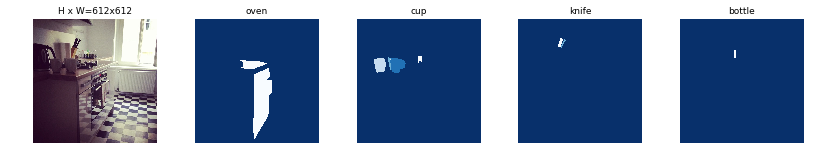

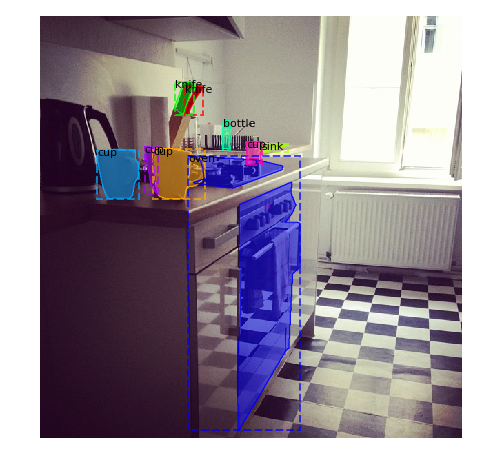

In [5]:
import mrcnn.utils as utils
# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = mrcnn_model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(mrcnn_config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
#     print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)
    visualize.display_instances_with_mask(image, bbox, mask, class_ids, dataset_train.class_names, figsize =(8,8))  

##  Pass data thru model

In [6]:
mrcnn_model.layer_info()
# model.keras_model.outputs[0].name



 Inputs:
 -------
 index:  0    input name : input_image:0                              Type: float32           Shape: (?, 1024, 1024, 3)
 index:  1    input name : input_image_meta:0                         Type: float32           Shape: (?, ?)
 index:  2    input name : input_rpn_match:0                          Type: int32             Shape: (?, ?, 1)
 index:  3    input name : input_rpn_bbox:0                           Type: float32           Shape: (?, ?, 4)
 index:  4    input name : input_gt_class_ids:0                       Type: int32             Shape: (?, ?)
 index:  5    input name : input_gt_boxes:0                           Type: float32           Shape: (?, ?, 4)


 Outputs:
 --------
 layer:  0    output name: cntxt_layer/pred_heatmap_norm:0            Type: float32           Shape: (1, 256, 256, 81)
 layer:  1    output name: cntxt_layer/pred_heatmap_scores:0          Type: float32           Shape: (1, 81, 200, 11)
 layer:  2    output name: cntxt_layer_gt/gt_heatmap

In [7]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(mrcnn_model.keras_model, train_batch_x, [0,1,2,3], 1)


/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (1, 1024, 1024, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (1, 89)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (1, 261888, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (1, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (1, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (1, 100, 4)

/* Outputs */
Output idx:  0    Layer:  0: (cntxt_layer/pred_heatmap_norm:0         ) 	  Output shape: (1, 256, 256, 81)
Output idx:  1    Layer:  1: (cntxt_layer/pred_heatmap_scores:0       ) 	  Output shape: (1, 81, 200, 11)
Output idx:  2    Layer:  2: (cntxt_layer_gt/gt_heatmap:0             ) 	  Output shape: (1, 256, 256, 81)
Output idx:  3    Layer:  3: (cntxt_layer_gt/gt_heatmap_scores:0      ) 	  Output shape: (1, 81, 200, 11)

Number of layers generated:  4 

pred_heatmap_norm

In [8]:
print(len(model_output))
# rpn_class_logits          = model_output[0]          # layer:  0   shape: (5, 4092, 2)
# rpn_class                 = model_output[1]          # layer:  1   shape: (5, 4092, 2)
# rpn_bbox                  = model_output[2]          # layer:  2   shape: (5, 4092, 4)
# rpn_roi_proposals         = model_output[3]          # layer:  3   shape: (5, 2000, 4)
# output_rois               = model_output[4]          # layer:  4   shape: (5, 32, 4)
# target_class_ids          = model_output[5]          # layer:  5   shape: (5, 32)
# target_bbox_deltas        = model_output[6]          # layer:  6   shape: (5, 32, 4)
# roi_gt_boxes              = model_output[7]          # layer:  7   shape: (5, 32, 4)
# pred_heatmap_norm         = model_output[8]          # layer: 15   shape: (5, 128, 128, 4)
# gt_heatmap_norm           = model_output[9]          # layer: 16   shape: (5, 128, 128, 4)
# pred_heatmap_scores       = model_output[10]          # layer: 17   shape: (5, 4, 32, 11)
# gt_heatmap_scores         = model_output[11]          # layer: 18   shape: (5, 4, 32, 11)
# pred_tensor               = model_output[12]          # layer: 19   shape: (5, 4, 32, 6)
# gt_tensor                 = model_output[13]          # layer: 20   shape: (5, 4, 32, 6)
# pred_heatmap              = model_output[14]          # layer: 21   shape: (5, 128, 128, 4)
# gt_heatmap                = model_output[15]          # layer: 22   shape: (5, 128, 128, 4)
# fcn_heatmap_norm          = model_output[16]          # layer: 23   shape: (5, 128, 128, 4)
# fcn_heatmap_scores        = model_output[17]          # layer: 24   shape: (5, 4, 32, 16)
# fcn_heatmap               = model_output[18]          # layer: 25   shape: (5, 128, 128, 4)
# fcn_normalized_loss       = model_output[19]          # layer: 26   shape: (1, 1)
# del pred_heatmap_norm, pred_heatmap_scores, gt_heatmap, gt_heatmap_scores
model_pred_heatmap_norm         = model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
model_pred_heatmap_scores       = model_output[1]          # layer:  1   shape: (1, 81, 200, 11)
model_gt_heatmap                = model_output[2]          # layer:  2   shape: (1, 256, 256, 81)
model_gt_heatmap_scores         = model_output[3]          # layer:  3   shape: (1, 81, 200, 11)

for i in model_output:
    print( i.shape)

4
(1, 256, 256, 81)
(1, 81, 200, 11)
(1, 256, 256, 81)
(1, 81, 200, 11)


In [ ]:
print(fcn_normalized_loss)

In [ ]:
input_image      =  train_batch_x[0]
input_image_meta =  train_batch_x[1]
input_rpn_match  =  train_batch_x[2]
input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes    = train_batch_x[5]
input_gt_masks     = train_batch_x[6]
print(' Input image shape is :', input_image.shape)
h, w = input_image.shape[1], input_image.shape[2]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

# gt_masks   =  train_batch_x[6]
print(' input_rpn_match    ', input_rpn_match.shape)
print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids ', input_gt_class_ids.shape)
print(' input_gt_bboxes    ', input_gt_bboxes.shape)
print(' input_normlzd_gt_bboxes    ', input_normlzd_gt_bboxes.shape)
print(input_image_meta)

## Display Input / Output

####  display Pred_Tensor, Pred_heatmap, mrcnn_class

In [15]:
np.set_printoptions(precision=4, threshold=None, linewidth=210, suppress=True)
img = 0

# print(KB.int_shape(output_rois))
# print(output_rois[img,:15]*[128, 128,128,128])
# print(input_gt_class_ids[0])

# print(' Pred_tensor')
# print(pred_tensor.shape)
# print(pred_tensor[img,:,:10])

# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])

# print(' output_rois')
# print(output_rois.shape)
# print(output_rois[img,:15] * [128, 128,128,128])


# print(' roi_gt_boxes')
# print(roi_gt_boxes.shape)
# print(roi_gt_boxes[img,:15] * [128, 128,128,128])

print(' Pred Heatmap Scores')
print(pred_heatmap_scores.dtype)


print(' FCN Scores')
# print(fcn_scores.dtype)
# for cls in range(4):
#     for box in range(25):
#         print(pred_heatmap_scores[img,cls,box])
#         print(gt_heatmap_scores[img, cls,box])
#         print()
#     print(fcn_scores[img,cls,:10,2:])

# img = 2
# max_score = np.max(mrcnn_class, axis = -1)
# max_class = np.argmax(mrcnn_class, axis = -1)
# # print(' output_rois[',img,'] \n', output_rois[1]*[128,128,128,128])
# print('max class shape:',max_class.shape, 'max score shape: ',max_score.shape)
# print('max class[',img,']\n',max_class[img])
# print('max score[',img,']\n',max_score[img])
# print('mrcnn class.shape ',mrcnn_class.shape)
# print('mrcnn_class[',img,',:]\n',mrcnn_class[img,:])
# print(output_rois[1])
 

 Pred Heatmap Scores
float32
 FCN Scores


####  Display `output_rois` for visual check - passed on to  `build_pred_tensor()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('output_rois shape is ', output_rois.shape)
img = 0
for img in range(5):
    print('Image ', img , ' ------------')
    print(output_rois[img]*[128,128,128,128])

####  Display for visual check - `pred_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_tensor shape is ', pred_tensor.shape)
img = 0
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(pred_tensor[img,k])

####  Display for visual check - `gt_tensor` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_tensor shape is ', gt_tensor.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_tensor[img,k])

####  Display for visual check - `pred_heatmap_scores` is the final result which is passed from  `build_gaussian_tf()`

In [ ]:
# with sess.as_default():
np.set_printoptions(linewidth=150, precision=6, suppress=True)
# print('scatter shape is ', pred_scatt.get_shape())
print('pred_heatmap_scores shape is ', pred_heatmap_scores.shape)
for img in [0,1,2]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(np.min(pred_heatmap_scores[img,k,:,8]))
        print(pred_heatmap_scores[img,k])

####  Display for visual check - `GT_HEATMAP_SCORES` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, precision=6)
print('gt_heatmap_scores shape is ', gt_heatmap_scores.shape)
img = 1
for k in range(4):
    print('Image ', img , '/ Class ',k,' ------------')
    print(gt_heatmap_scores[img,k])

####  Display for visual check - `FCN_HEATMAP_SCORES` is the final result which is passed on to  `build_gaussian_tf()`

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision=2)
temp = fcn_heatmap_scores
print('fcn_heatmap_scores shape is ', temp.shape)
# img = 1
for img in [1,2,3]:
    for k in range(4):
        print('Image ', img , '/ Class ',k,' ------------')
        print(temp[img,k])
    

####  Display for visual check - `pred_heatmap_norm` is the final result from  `build_gaussian_tf()`

In [ ]:
print(pred_heatmap_norm.shape)
temp = pred_heatmap_norm
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


####  Display for visual check - `fcn_heatmap is the final result from  `FCN`

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap_norm
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, suppress=False)
temp = fcn_heatmap
print('  Temp shape :',  temp.shape)
temp_sum = np.sum(temp,axis=(1,2))
print('temp_sum is ', temp_sum.shape)
for i in range(5):
    for j in range(4):
        print('img ',i,' class ', j, ' sum:',temp_sum[i,j],  ' max: ',np.max(temp[i,:,:,j]),' mean: ', np.mean(temp[i,:,:,j]),' min: ', np.min(temp[i,:,:,j]))    


# sess = KB.get_session()
# with sess.as_default():
#     temp = tf.identity(fcn_heatmap
#     np.set_printoptions(linewidth=150, threshold=10000)
#     print('  output shapes :',  temp.get_shape())
#     temp_sum = tf.reduce_sum(temp, [2,3])
#     temp_min = tf.reduce_min(temp, [2,3])
#     temp_max = tf.reduce_max(temp, [2,3])
#     temp_avg = tf.reduce_mean(temp, [2,3])
#     print('temp_sum is ', temp_sum.shape)
#     for i in range(5):
#         for j in range(4):
#                 print('img/cls ',i,'/', j,'  sum:',temp_sum[i,j], 'min',temp_min[i,j] ,'max',temp_max[i,j] ,'avg',temp_avg[i,j])

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000, precision = 6,suppress=False)
sess = KB.get_session()
with sess.as_default():
    tmp = tf.identity(fcn_heatmap)
    print(tf.shape(tmp).eval())
    reduce_max = tf.reduce_max(tmp,axis = [1,2], keepdims=True)
    print(tf.shape(reduce_max).eval())
    reduce_min = tf.reduce_min(tmp, axis = [1,2], keepdims=True)
    print(tf.shape(reduce_min).eval())
    print(reduce_min.eval())
    print(reduce_max.eval())
    y  =  (tmp - reduce_min) / (reduce_max - reduce_min)        
    print(tf.shape(y).eval())

####  Display for visual check - `gt_heatmap_scores`  and `fcn_heatmap_scores` 

In [48]:
np.set_printoptions(precision=4, threshold=None, linewidth=200, suppress=True)
# print(' gt_tensor')
# print(gt_tensor.shape)
# print(gt_tensor[img,:,:10])
img_id = 1
print(' GT Heatmap Scores')

print('gt_heatmap_scores: ', model_gt_heatmap_scores.dtype,  model_gt_heatmap_scores.shape)
print('pred_heatmap_scores: ', model_pred_heatmap_scores.dtype,  model_pred_heatmap_scores.shape)

# print(gt_heatmap_scores[img,1])
# for img_id in range(mrcnn_config.BATCH_SIZE):

for img_id in [0]:    # print(pred_refined_heatmap_scores[img_id,:4])
    pr_class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    gt_class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist() 
    union_class_ids = np.union1d(pr_class_ids, gt_class_ids)
    print('-'*56)
    print('Image : {}  GT ClassIds: {}   PR ClassIds: {} '.format(img_id, gt_class_ids, pr_class_ids))
    print('Image : {}  Union ClassIds: {}'.format(img_id, union_class_ids))
    print('-'*56)
    for cls in union_class_ids:  
        print()
        for i in range(10):
#             print(' GT: img_id:',img_id, ' cls: ',cls, ' -',gt_tensor[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
#             print(' PR: img_id:',img_id, ' cls: ',cls, ' -',pred_tensor[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])

            print(' GT: img_id:',img_id, ' cls: ',cls, ' -',model_gt_heatmap_scores[img_id, cls,i]) #, gt_heatmap_scores[img_id, cls,i,7] )
            print(' PR: img_id:',img_id, ' cls: ',cls, ' -',model_pred_heatmap_scores[img_id,cls,i]) #,pred_refined_heatmap_scores[img_id,cls,i,7])
            print()

 GT Heatmap Scores
gt_heatmap_scores:  float32 (1, 81, 200, 11)
pred_heatmap_scores:  float32 (1, 81, 200, 11)
--------------------------------------------------------
Image : 0  GT ClassIds: [0, 1, 34]   PR ClassIds: [0, 1, 34] 
Image : 0  Union ClassIds: [ 0  1 34]
--------------------------------------------------------

 GT: img_id: 0  cls:  0  - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 PR: img_id: 0  cls:  0  - [252.978  136.4298 297.864  184.3816   0.       0.8723 198.       0.8723   0.9721 134.5226   0.848 ]

 GT: img_id: 0  cls:  0  - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 PR: img_id: 0  cls:  0  - [282.2729 780.7172 295.1017 796.4708   0.       0.4455 195.       0.4455   0.6844  12.6311   0.3049]

 GT: img_id: 0  cls:  0  - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 PR: img_id: 0  cls:  0  - [280.4072 786.527  290.7699 800.4031   0.       0.6815 190.       0.6815   0.6383   8.9872   0.435 ]

 GT: img_id: 0  cls:  0  - [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 PR: img_id: 0  cls:  0  - [239.3109 15

In [ ]:
print(fcn_normalized_loss)

##  Build FCN Model 

In [9]:

FCN_TRAINING_PATH = "F:/models/train_fcn_coco"
FCN_VGG16_MODEL_PATH  = "F:/PretrainedModels/fcn_vgg16_weights_tf_dim_ordering_tf_kernels.h5"
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.TRAINING_PATH        = FCN_TRAINING_PATH
# mrcnn_config.COCO_DATASET_PATH  = COCO_DATASET_PATH 
# mrcnn_config.COCO_MODEL_PATH    = COCO_MODEL_PATH   
# mrcnn_config.RESNET_MODEL_PATH  = RESNET_MODEL_PATH 
fcn_config.VGG16_MODEL_PATH     = FCN_VGG16_MODEL_PATH
fcn_config.FCN_INPUT_SHAPE      = mrcnn_config.IMAGE_SHAPE[0:2] // mrcnn_config.HEATMAP_SCALE_FACTOR 
fcn_config.WEIGHT_DECAY         = 2.0e-4
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 5
fcn_config.REDUCE_LR_PATIENCE   = 5
fcn_config.EARLY_STOP_PATIENCE  = 15
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10

fcn_config.BATCH_SIZE           = 1                # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1                  # Must match BATCH_SIZE
fcn_config.EPOCHS_TO_RUN        = 1
  
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.WEIGHT_DECAY         = 2.0e-4
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'

fcn_config.display()




Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8

In [10]:
     ##------------------------------------------------------------------------------------
## Build FCN Model in Training Mode
##------------------------------------------------------------------------------------
try :
    del fcn_model
    gc.collect()
except: 
    pass    
fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)

>>> Initialize ModelBase model 
   Mode      :  training
   Model dir :  F:/models/train_fcn_coco
>>> ModelBase initialiation complete
>>> Initialize FCN model, mode:  training


---------------------------------------------------
    Adding  FCN layers
---------------------------------------------------

>>> FCN Layer 
     feature map      : (?, 256, 256, 81)
     height : 256 width : 256 classes : 81
     image_data_format:  channels_last
     rois_per_class   :  channels_last
   FCN Block 11 shape is :  (?, 256, 256, 64)
   FCN Block 12 shape is :  (?, 256, 256, 64)
   FCN Block 13 shape is :  (?, 128, 128, 64)
   FCN Block 21 shape is :  (?, 128, 128, 128)
   FCN Block 22 shape is :  (?, 128, 128, 128)
   FCN Block 23 (Max pooling) shape is :  (?, 64, 64, 128)
   FCN Block 31 shape is :  (?, 64, 64, 256)
   FCN Block 32 shape is :  (?, 64, 64, 256)
   FCN Block 33 shape is :  (?, 64, 64, 256)
   FCN Block 34 (Max pooling) shape is :  (?, 32, 32, 256)
   FCN Block 41 shape is :  (?

In [11]:
##------------------------------------------------------------------------------------
## Load FCN Model weights  
##------------------------------------------------------------------------------------
# fcn_model.load_model_weights(init_with = 'last') # 'fcn_config.VGG16_MODEL_PATH')
fcn_model.load_model_weights(init_with = 'F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5')

-----------------------------------------------
 Load Model with init parm: [ F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5
 List Model layers and matching hd5 layers, if present :     
    0  input_pr_hm_norm..............  1 
    1  block1_conv1..................  1 
    2  block1_conv2..................  1 
    3  block1_pool...................  1 
    4  block2_conv1..................  1 
    5  block2_conv2..................  1 
    6  block2_pool...................  1 
    7  block3_conv1..................  1 
    8  block3_conv2..................  1 
    9  block3_conv3..................  1 
   10  block3_pool...................  1 
   11  block4_conv1..................  1 
   12  block4_conv2..................  1 
   13  block4_conv3..................  1 
   14  block4_pool...................  1 
   15  block5_conv1

   Weights file loaded: F:/models/train_fcn_coco/fcn20181020T1200/fcn_0056.h5 
    set_log_dir: self.epoch set to 0  (Next epoch to run)
    set_log_dir: tensorboard path: F:/models/train_fcn_coco\tensorboard
NewFolder: False  config.NEW_LOG_FOLDER: True 
  set_log_dir(): self.Checkpoint_path: F:/models/train_fcn_coco\fcn20181022T1439\fcn_{epoch:04d}.h5 
  set_log_dir(): self.log_dir        : F:/models/train_fcn_coco\fcn20181022T1439 
  set_log_dir(): Last completed epoch (self.epoch): 57 
FCN  MODEL Load weight file COMPLETE    


In [12]:
fcn_model.config.display()  
fcn_model.layer_info()


Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN                 0
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8

In [18]:
# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
# fcn_train_batch_x = [model_gt_heatmap, model_gt_heatmap_scores, model_gt_heatmap, model_gt_heatmap_scores]
# fcn_train_batch_x = model_output
fcn_train_batch_x = [model_pred_heatmap_norm, model_pred_heatmap_scores, model_gt_heatmap, model_gt_heatmap_scores]

fcn_model_output = get_layer_output_1(fcn_model.keras_model, fcn_train_batch_x, [0,1], 1)


/* Inputs */
Input  0:  (input_pr_hm_norm:0                      ) 	  Input shape: (1, 256, 256, 81)
Input  1:  (input_pr_hm_scores:0                    ) 	  Input shape: (1, 81, 200, 11)
Input  2:  (input_gt_hm_norm:0                      ) 	  Input shape: (1, 256, 256, 81)
Input  3:  (input_gt_hm_scores:0                    ) 	  Input shape: (1, 81, 200, 11)

/* Outputs */
Output idx:  0    Layer:  0: (fcn_heatmap/fcn_heatmap:0               ) 	  Output shape: (1, 256, 256, 81)
Output idx:  1    Layer:  1: (fcn_heatmap_loss/Mean:0                 ) 	  Output shape: ()

Number of layers generated:  2 

fcn_heatmap               = model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
Mean                      = model_output[1]          # layer:  1   shape: ()


In [19]:
model_fcn_heatmap               = fcn_model_output[0]          # layer:  0   shape: (1, 256, 256, 81)
model_Mean                      = fcn_model_output[1]          # layer:  1   shape: ()

In [58]:
# hm_sum = np.sum(model_fcn_heatmap, axis=(1,2))
print(model_Mean)

0.009247538


In [46]:
for i in range(10):
    print(np.min(model_fcn_heatmap[0,:,:,i], axis = (0,1)), np.max(model_fcn_heatmap[0,:,:,i], axis = (0,1)), np.sum(model_fcn_heatmap[0,:,:,i]))
    print(np.min(model_gt_heatmap[0,:,:,i], axis = (0,1)), np.max(model_gt_heatmap[0,:,:,i], axis = (0,1)), np.sum(model_gt_heatmap[0,:,:,i]))

-8.9401405e-15 4.87005e-16 -2.3730687e-10
0.0 0.0 0.0
-4.615194 -4.615194 -302461.34
0.0 0.0 0.0
-4.714449 -4.7144475 -308966.03
0.0 0.0 0.0
-4.7031236 -4.703122 -308223.84
0.0 0.0 0.0
-4.7103014 -4.7103 -308694.25
0.0 0.0 0.0
-4.714801 -4.7147994 -308989.1
0.0 0.0 0.0
-4.7109323 -4.710931 -308735.53
0.0 0.0 0.0
-4.7180567 -4.7180557 -309202.5
0.0 0.0 0.0
-4.712316 -4.7123146 -308826.28
0.0 0.0 0.0
-4.7135296 -4.713528 -308905.78
0.0 0.0 0.0


In [25]:
# print(model_fcn_heatmap[0,0:10,:10,1])

In [27]:
# for i in range(10):
#     print(model_fcn_heatmap[0,i,:,4])
#     print(np.min(model_fcn_heatmap[0,i,:,1]), np.max(model_fcn_heatmap[0,i,:,1]))

## Calculate FCN Loss on heatmap

In [31]:
target_heatmap = tf.identity(model_gt_heatmap)
pred_heatmap  = tf.identity(model_fcn_heatmap)

In [33]:
print(target_heatmap, pred_heatmap)

Tensor("Identity_2:0", shape=(1, 256, 256, 81), dtype=float32) Tensor("Identity_3:0", shape=(1, 256, 256, 81), dtype=float32)


In [59]:
sess = KB.get_session()
print(' New session obtained from Kras', sess)
import keras.losses as KLosses
losses = {}
losses_mean = {}
print()
print('---------------------------' )
print('>>> fcn_heatmap_loss_graph ' )
print('---------------------------' )
print('    target_masks :', target_heatmap.get_shape(), KB.shape(target_heatmap), 'KerasTensor: ', KB.is_keras_tensor(target_heatmap))
print('    pred_heatmap :', pred_heatmap.get_shape()  , KB.shape(pred_heatmap)  , 'KerasTensor: ', KB.is_keras_tensor(pred_heatmap))

loss = KB.binary_crossentropy(target_heatmap[...,1:], pred_heatmap[...,1:], from_logits= True)
loss_mean = KB.mean(loss)
print('loss: ',loss.shape)    
print('loss_mean: ', loss_mean.shape)

loss2 = KB.categorical_crossentropy(target_heatmap[...,1:], pred_heatmap[...,1:], from_logits=True)
loss_mean2 = KB.mean(loss2)
print('loss2: ',loss2.shape)
print('loss_mean2: ',loss_mean2.shape)

loss3 = KLosses.mean_squared_error(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean3 = KB.mean(loss3)
print('loss3: ',loss3.shape)
print('loss_mean3: ',loss_mean3.shape)

loss4 = KLosses.mean_absolute_error(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean4 = KB.mean(loss4)
print('loss4: ',loss4.shape)
print('loss_mean4: ',loss_mean4.shape)
 
loss5 = KLosses.mean_squared_logarithmic_error(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean5 = KB.mean(loss5)
print('loss5: ',loss5.shape)
print('loss_mean5: ',loss_mean5.shape)

loss6 = KLosses.squared_hinge(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean6 = KB.mean(loss6)
print('loss6: ',loss6.shape)
print('loss_mean6: ',loss_mean6.shape)

loss7 = KLosses.hinge(target_heatmap[...,1:], pred_heatmap[...,1:])
loss_mean7 = KB.mean(loss7)
print('loss7: ',loss7.shape)
print('loss_mean7: ',loss_mean7.shape)

 New session obtained from Kras <tensorflow.python.client.session.Session object at 0x000000FDDD200B38>

---------------------------
>>> fcn_heatmap_loss_graph 
---------------------------
    target_masks : (1, 256, 256, 81) Tensor("Shape_22:0", shape=(4,), dtype=int32) KerasTensor:  False
    pred_heatmap : (1, 256, 256, 81) Tensor("Shape_23:0", shape=(4,), dtype=int32) KerasTensor:  False
loss:  (1, 256, 256, 80)
loss_mean:  ()
loss2:  (1, 256, 256)
loss_mean2:  ()
loss3:  (1, 256, 256)
loss_mean3:  ()
loss4:  (1, 256, 256)
loss_mean4:  ()
loss5:  (1, 256, 256)
loss_mean5:  ()
loss6:  (1, 256, 256)
loss_mean6:  ()
loss7:  (1, 256, 256)
loss_mean7:  ()


In [60]:
with sess.as_default():
    r_loss_mean = loss_mean.eval()
    r_loss_mean2= loss_mean2.eval()
    r_loss_mean3= loss_mean3.eval()
    r_loss_mean4= loss_mean4.eval()
    r_loss_mean5= loss_mean5.eval()
    r_loss_mean6= loss_mean6.eval()
    r_loss_mean7= loss_mean7.eval()

In [63]:
print('Binary Cross Entropy (logits)     : ', r_loss_mean)
print('Categorical Cross Entropy (logits): ', r_loss_mean2)
print('Mean Squared error            : ', r_loss_mean3)
print('Mean Absolute error           : ', r_loss_mean4)
print('mean_squared_logarithmic_error: ', r_loss_mean5)
print('squared_hinge                 : ', r_loss_mean6)
print('hinge                         : ', r_loss_mean7)

Binary Cross Entropy (logits)     :  0.009247538
Categorical Cross Entropy (logits):  0.028751496
Mean Squared error            :  22.2189
Mean Absolute error           :  4.713558
mean_squared_logarithmic_error:  3.940483e-05
squared_hinge                 :  1.0025958
hinge                         :  1.0003862


#### Try flattening the results. 

Results are same except for Categorical Cross Entropy

In [71]:
sess = KB.get_session()
print(' New session obtained from Kras', sess)
import keras.losses as KLosses
losses = {}
losses_mean = {}
print()
print('---------------------------' )
print('>>> fcn_heatmap_loss_graph ' )
print('---------------------------' )
print('    target_masks :', target_heatmap.get_shape(), KB.shape(target_heatmap), 'KerasTensor: ', KB.is_keras_tensor(target_heatmap))
print('    pred :', pred_heatmap.get_shape()  , KB.shape(pred_heatmap)  , 'KerasTensor: ', KB.is_keras_tensor(pred_heatmap))
trgt = tf.transpose(target_heatmap, [0, 3, 1, 2])
pred = tf.transpose(pred_heatmap, [0, 3, 1, 2])
print('    target_masks :', trgt.get_shape())
print('    pred :', pred.get_shape())
trgt = tf.reshape(trgt, [KB.shape(trgt)[0],KB.shape(trgt)[1],-1])
pred = tf.reshape(pred, [KB.shape(pred)[0],KB.shape(pred)[1],-1])
print('    target_masks :', trgt.get_shape())
print('    pred :', pred.get_shape())

loss = KB.binary_crossentropy(trgt[:,1:,:], pred[:,1:,:], from_logits= True)
loss_mean = KB.mean(loss)
print('loss: ',loss.shape)    
print('loss_mean: ', loss_mean.shape)

loss2 = KB.categorical_crossentropy(trgt[:,1:,:], pred[:,1:,:], from_logits=True)
loss_mean2 = KB.mean(loss2)
print('loss2: ',loss2.shape)
print('loss_mean2: ',loss_mean2.shape)

loss3 = KLosses.mean_squared_error(trgt[:,1:,:], pred[:,1:,:])
loss_mean3 = KB.mean(loss3)
print('loss3: ',loss3.shape)
print('loss_mean3: ',loss_mean3.shape)

loss4 = KLosses.mean_absolute_error(trgt[:,1:,:], pred[:,1:,:])
loss_mean4 = KB.mean(loss4)
print('loss4: ',loss4.shape)
print('loss_mean4: ',loss_mean4.shape)
 
loss5 = KLosses.mean_squared_logarithmic_error(trgt[:,1:,:], pred[:,1:,:])
loss_mean5 = KB.mean(loss5)
print('loss5: ',loss5.shape)
print('loss_mean5: ',loss_mean5.shape)

loss6 = KLosses.squared_hinge(trgt[:,1:,:], pred[:,1:,:])
loss_mean6 = KB.mean(loss6)
print('loss6: ',loss6.shape)
print('loss_mean6: ',loss_mean6.shape)

loss7 = KLosses.hinge(trgt[:,1:,:], pred[:,1:,:])
loss_mean7 = KB.mean(loss7)
print('loss7: ',loss7.shape)
print('loss_mean7: ',loss_mean7.shape)

 New session obtained from Kras <tensorflow.python.client.session.Session object at 0x000000FDDD200B38>

---------------------------
>>> fcn_heatmap_loss_graph 
---------------------------
    target_masks : (1, 256, 256, 81) Tensor("Shape_49:0", shape=(4,), dtype=int32) KerasTensor:  False
    pred : (1, 256, 256, 81) Tensor("Shape_50:0", shape=(4,), dtype=int32) KerasTensor:  False
    target_masks : (1, 81, 256, 256)
    pred : (1, 81, 256, 256)
    target_masks : (?, ?, ?)
    pred : (?, ?, ?)
loss:  (?, ?, ?)
loss_mean:  ()
loss2:  (?, ?)
loss_mean2:  ()
loss3:  (?, ?)
loss_mean3:  ()
loss4:  (?, ?)
loss_mean4:  ()
loss5:  (?, ?)
loss_mean5:  ()
loss6:  (?, ?)
loss_mean6:  ()
loss7:  (?, ?)
loss_mean7:  ()


In [72]:
with sess.as_default():
    r_loss_mean = loss_mean.eval()
    r_loss_mean2= loss_mean2.eval()
    r_loss_mean3= loss_mean3.eval()
    r_loss_mean4= loss_mean4.eval()
    r_loss_mean5= loss_mean5.eval()
    r_loss_mean6= loss_mean6.eval()
    r_loss_mean7= loss_mean7.eval()

In [73]:
print('Binary Cross Entropy (logits)     : ', r_loss_mean)
print('Categorical Cross Entropy (logits): ', r_loss_mean2)
print('Mean Squared error            : ', r_loss_mean3)
print('Mean Absolute error           : ', r_loss_mean4)
print('mean_squared_logarithmic_error: ', r_loss_mean5)
print('squared_hinge                 : ', r_loss_mean6)
print('hinge                         : ', r_loss_mean7)

Binary Cross Entropy (logits)     :  0.009255492
Categorical Cross Entropy (logits):  59.610603
Mean Squared error            :  22.222755
Mean Absolute error           :  4.714963
mean_squared_logarithmic_error:  3.9404847e-05
squared_hinge                 :  1.0025951
hinge                         :  1.0003865


## Display Heatmaps

In [76]:
from mrcnn.visualize import plot_one_bbox_heatmap, plot_3d_heatmap, plot_3d_heatmap_all_classes, plot_2d_heatmap, plot_2d_heatmap_with_bboxes
import matplotlib as plt

%matplotlib inline
print('Image id: ',image_id)
img_id = 0
class_names = dataset_train.class_names

Image id:  2428


### Plot 2D heatmap of  one `pred_heatmap` distribution generated in `build_heatmap`

####  2D plot of `pred_heatmap_norm` returned from model : `model_pred_heatmap_norm`

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 40, 42, 44, 45, 70]
height is  36
256 256
x1, x2...shapes: (81, 200) (81, 200) (81, 200) (81, 200) (81, 200) (81, 200)


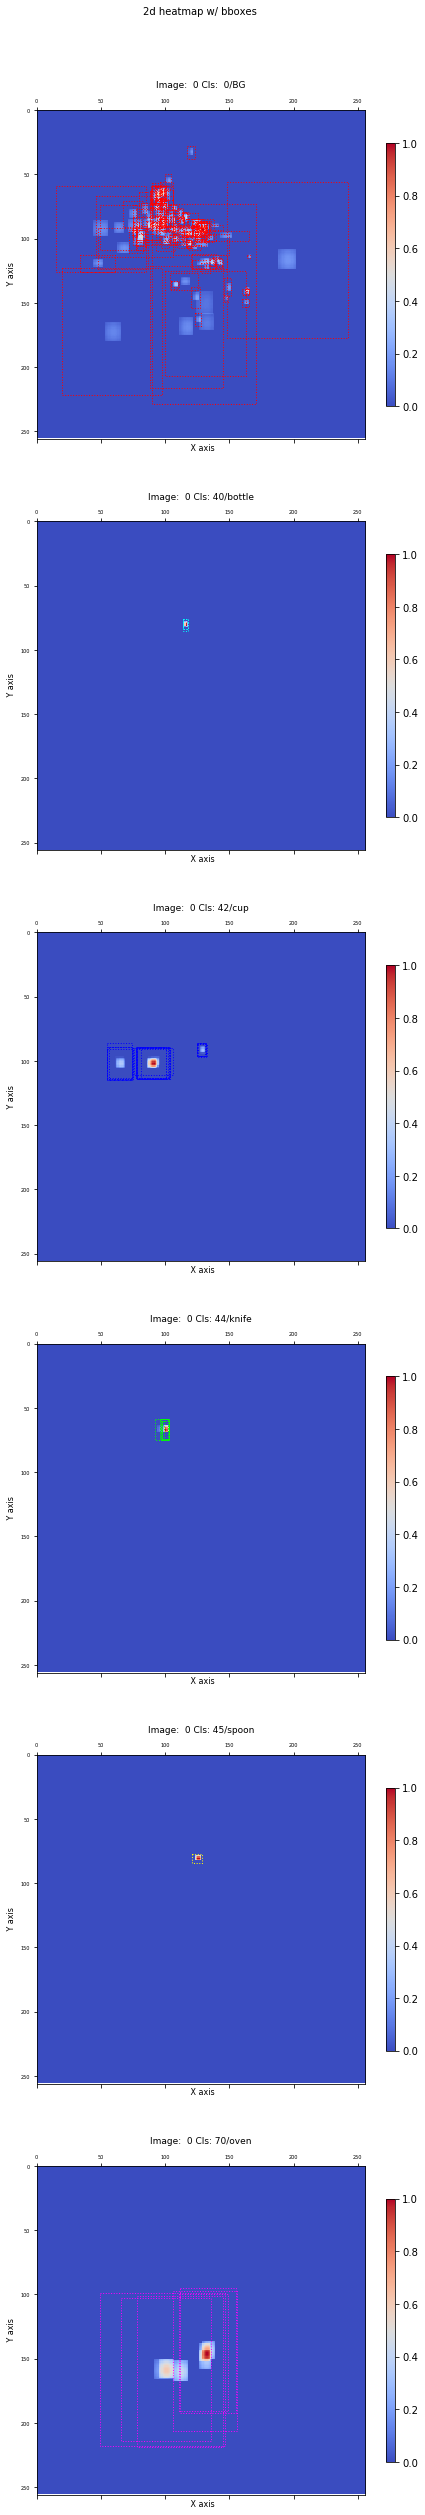

In [77]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    # print(pred_refined_heatmap_scores[img_id,:4])
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    
    plot_2d_heatmap_with_bboxes(model_pred_heatmap_norm, model_pred_heatmap_scores, 
                                img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)
#     plot_2d_heatmap_with_bboxes( pred_heatmap_norm,  pred_heatmap_scores, 
#                                 img_id, [0], width=6, height=6, class_names = class_names, scale = 4)    
    
#     plot_2d_heatmap(pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


####  2D plot of `model_gt_heatmap_norm` returned from model

(1, 256, 256, 81) (1, 81, 200, 11)
Image : 0  ClassIds: [0, 40, 42, 44, 70, 72]
height is  36
256 256
x1, x2...shapes: (81, 200) (81, 200) (81, 200) (81, 200) (81, 200) (81, 200)


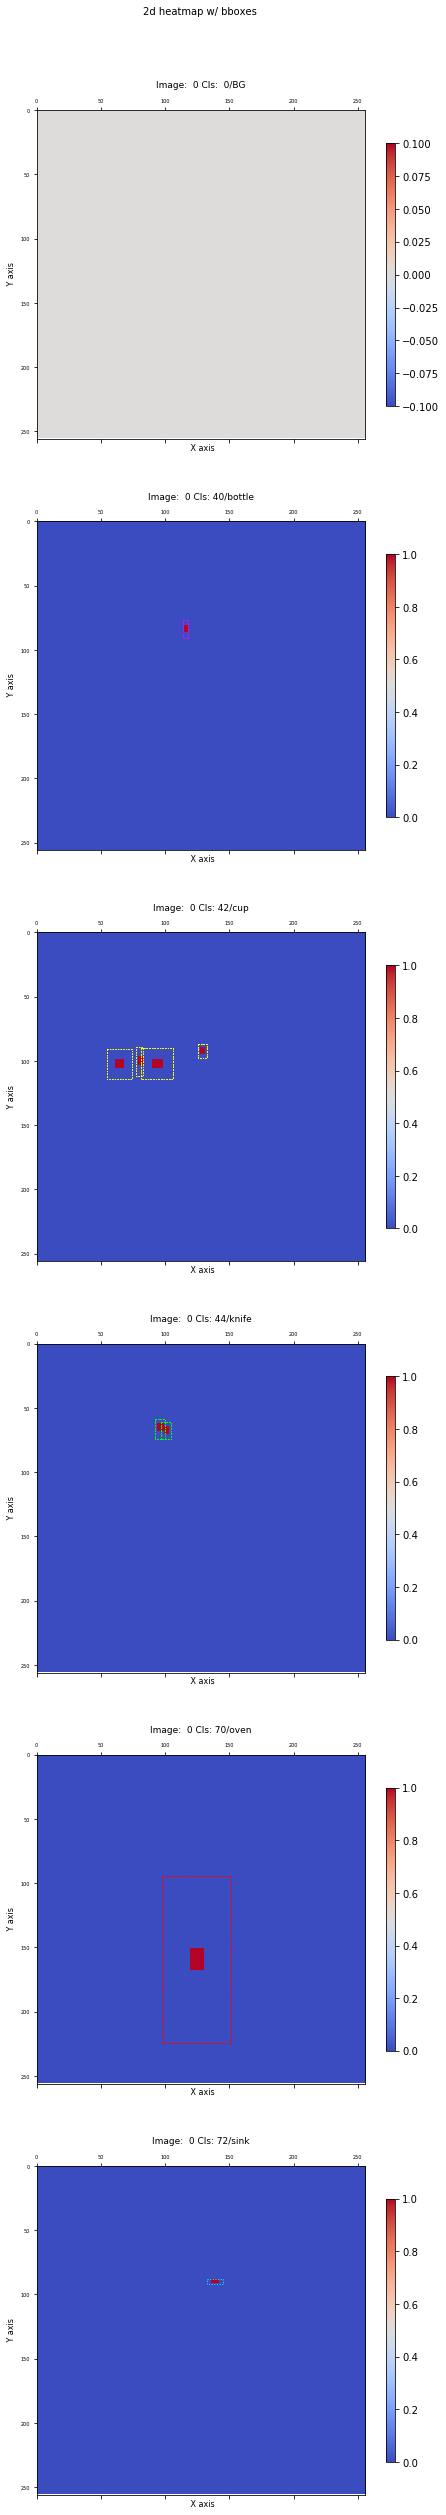

In [88]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape, model_gt_heatmap_scores.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes(model_gt_heatmap, model_gt_heatmap_scores, 
                                img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

####  2D plot of `model_fcn_heatmap_norm` returned from model

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 40, 42, 44, 70, 72]
height is  36
256 256
x1, x2...shapes: (81, 200) (81, 200) (81, 200) (81, 200) (81, 200) (81, 200)


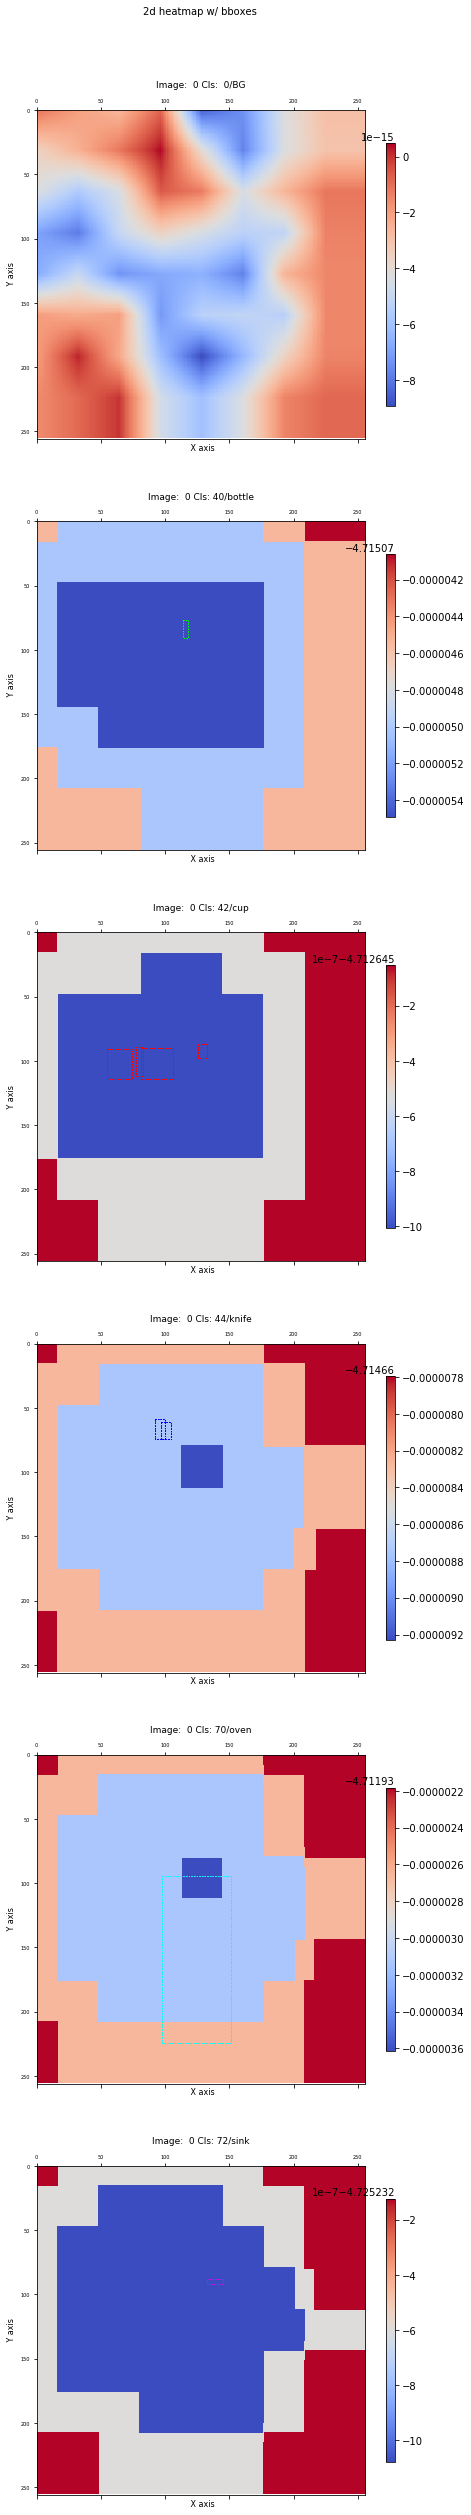

In [87]:
for img_id in [0]:     ##range(mrcnn_config.BATCH_SIZE):
    print(model_fcn_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_2d_heatmap_with_bboxes(model_fcn_heatmap, model_gt_heatmap_scores, 
                                img_id, class_ids, width=6, height=6, class_names = class_names, scale = 4)

###  3D Plots

####  3D plot of `model_pred_heatmap_norm` returned form model

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 40, 42, 44, 45, 70]
height is  36
shape pos  (256, 256, 2) shape Z:  (256, 256)


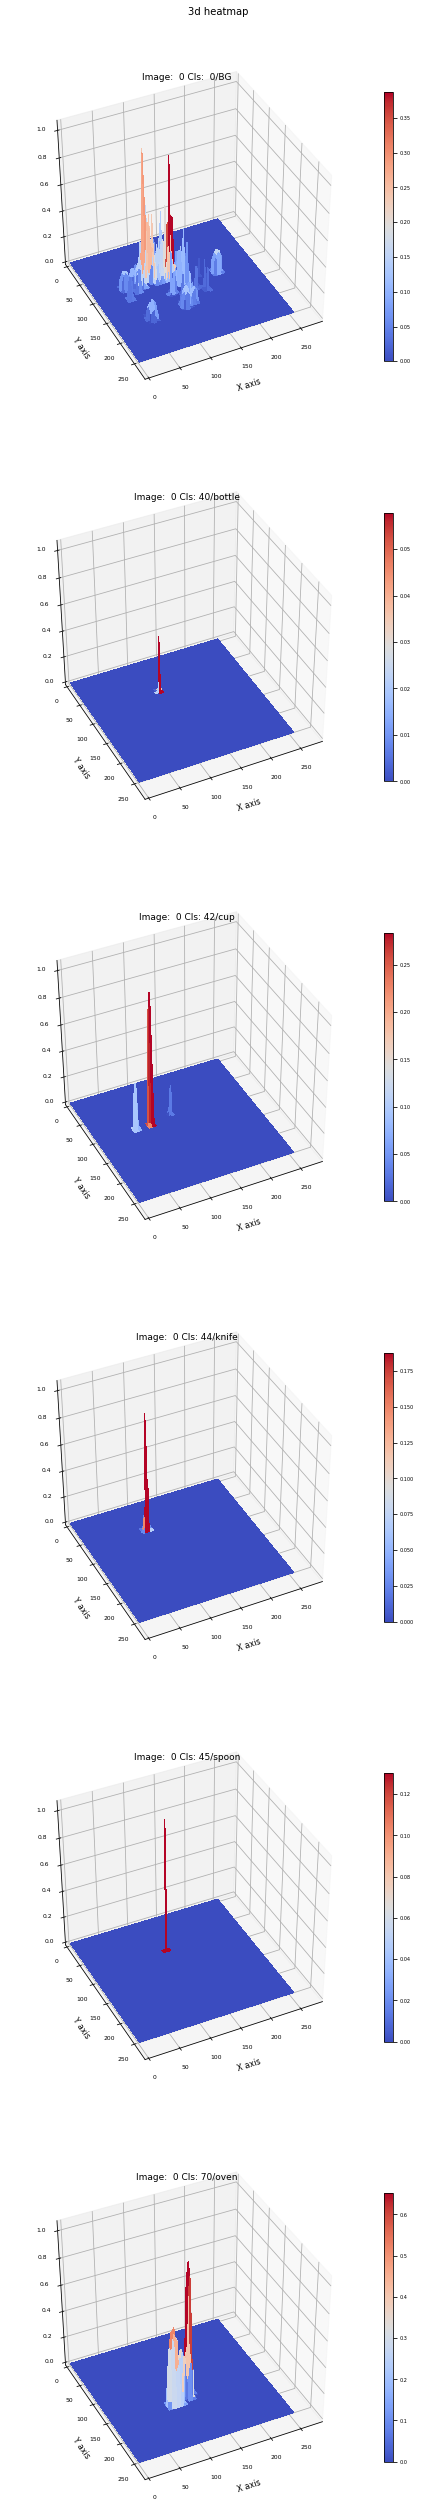

In [84]:
for img_id in [0]: ##range(mrcnn_config.BATCH_SIZE):
    print(model_pred_heatmap_norm.shape)
    class_ids = np.unique(model_pred_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_pred_heatmap_norm, img_id, class_ids, width=6, height=6, class_names = class_names)


####  3D plot of  `model_gt_heatmap_norm` returned form code above

(1, 256, 256, 81)
Image : 0  ClassIds: [0, 40, 42, 44, 70, 72]
height is  36
shape pos  (256, 256, 2) shape Z:  (256, 256)


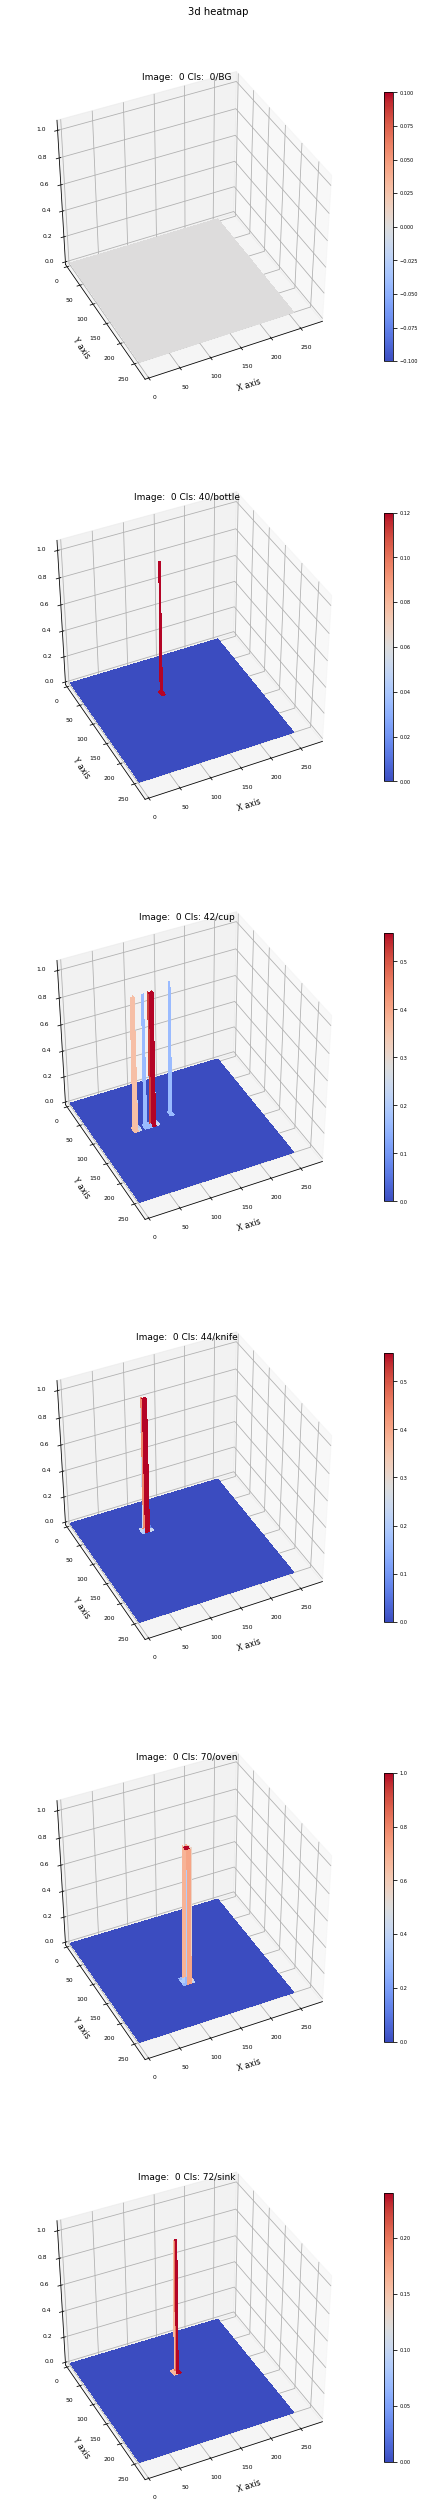

In [85]:
for img_id in [0]: ## range(mrcnn_config.BATCH_SIZE):
    print(model_gt_heatmap.shape)
    class_ids = np.unique(model_gt_heatmap_scores[img_id,:,:,4]).astype(int).tolist()
    print('Image : {}  ClassIds: {}'.format(img_id, class_ids))
    plot_3d_heatmap(model_gt_heatmap, img_id, class_ids, width=6, height=6, class_names = class_names)


####  Display `pred_heatmap` / `fcn_heatmap` (not normalized, normlized)

In [ ]:
from mrcnn.visualize import plot_2d_heatmap
%matplotlib inline
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
print(pred_heatmap_scores[img,0,0])
plot_2d_heatmap(model_pred_heatmap[img], model_pred_heatmap_scores[img], width=19, num_bboxes = 10, title='Non-normalized')
# plot_2d_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=19, num_bboxes = 10, title='normalized')
plot_2d_heatmap(fcn_heatmap[img], fcn_heatmap_scores[img], width=19, num_bboxes = 10,  title='Non-normalized')
# plot_heatmaps(pred_heatmap, pred_heatmap_scores, width = 15, num_bboxes=12)

###  Display `gauss_heatmap` 3D heatmap (not normalized, normlized, L2 normalized)

Image id:  1797     Classes (1: circle, 2: square, 3: triangle ): 
height is  7
shape pos  (256, 256, 2) shape Z:  (256, 256)


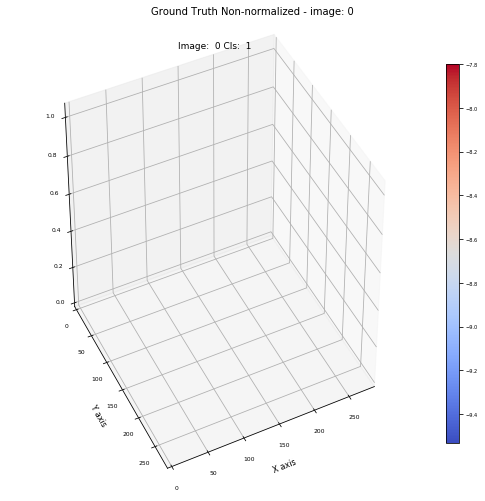

In [61]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap, plot_3d_gaussian
%matplotlib inline
print('Image id: ',image_id , '    Classes (1: circle, 2: square, 3: triangle ): ')
img = 0
cls = 0
# print(pred_heatmap_scores[img,cls,:10])

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

ttl = 'Ground Truth Non-normalized - image: {}'.format(img)
# plot_3d_gaussian(model_fcn_heatmap[img,1], title = ttl, width = 10)
# ttl = 'Ground Truth Normalized - image: {}'.format(img)
plot_3d_heatmap(model_fcn_heatmap, 0,[1], title = ttl)


# ttl = 'Non-normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap[img], pred_heatmap_scores[img], width=15, title=ttl)
# ttl = 'Normalized - image: {}'.format(img)
# plot_2d_heatmap(pred_heatmap_norm[img], pred_heatmap_scores[img], width=15, title=ttl)


In [ ]:
from mrcnn.visualize import plot_3d_heatmap, plot_2d_heatmap
%matplotlib inline
img = 0
cls = 1
# print(pred_heatmap_scores[img,cls,:10])

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(pred_heatmap_norm[img], title = ttl, width = 20)

# ttl = 'Non-normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap[img], title = ttl, width = 20)
# ttl = 'Normalized - image: {}'.format(img)
# plot_3d_heatmap(fcn_heatmap_norm[img], title = ttl, width = 20)

ttl = 'FCN - image: {}'.format(img)
plot_3d_heatmap(gt_heatmap[img], title = ttl, width = 20)
ttl = 'Ground Truth Normalized - image: {}'.format(img)
plot_3d_heatmap(gt_heatmap_norm[img], title = ttl, width = 20)


### Build `fcn_scores`

In [ ]:
def build_mask_routine(input_list):
    '''
    Inputs:
    -----------
        heatmap_tensor :    [ image height, image width ]
        input_row      :    [y1, x1, y2, x2] in absolute (non-normalized) scale

    Returns
    -----------
        gaussian_sum :      sum of gaussian heatmap vlaues over the area covered by the bounding box
        bbox_area    :      bounding box area (in pixels)
    '''
    heatmap_tensor, input_row = input_list
    with tf.variable_scope('mask_routine'):
        y_extent     = tf.range(input_row[0], input_row[2])
        x_extent     = tf.range(input_row[1], input_row[3])
        Y,X          = tf.meshgrid(y_extent, x_extent)
        bbox_mask    = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        mask         = tf.scatter_nd(mask_indices, mask_updates, tf.shape(heatmap_tensor))
        mask_sum    =  tf.reduce_sum(mask)
        mask_applied = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
        bbox_area    = tf.to_float((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]))
        gaussian_sum = tf.reduce_sum(mask_applied)
        ratio        = gaussian_sum / bbox_area 
        ratio        = tf.where(tf.is_nan(ratio),  0.0, ratio)  
    return tf.stack([gaussian_sum, bbox_area, ratio], axis = -1)

In [ ]:
##--------------------------------------------------------------------------
## setup input values
in_scores = tf.identity(pred_heatmap_scores)
in_heatmap = tf.identity(fcn_heatmap)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')

config = model.config
names = ['Dev']
##--------------------------------------------------------------------------


##----------------------------------------------------------------------------------------------------------------------          
##   build_fcn_scores 
##----------------------------------------------------------------------------------------------------------------------          
# def build_fcn_scores(self, in_heatmap, in_scores, names = None):
sess = KB.get_session()
with sess.as_default():


    num_detections  = config.DETECTION_MAX_INSTANCES
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    print('\n ')
    print('  > NEW build_heatmap() for ', names )
    print('    orignal in_heatmap shape : ', in_heatmap.shape)       
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES
    rois_per_image  = KB.int_shape(in_scores)[2] 
    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num of bboxes per class is : ', rois_per_image )

    ##--------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bounding box masks 
    ## NOTE: Score is generated on NORMALIZED gaussian distributions (GAUSS_NORM)
    ##       If want to do this on NON-NORMALIZED, we need to apply it on GAUSS_SUM
    ##--------------------------------------------------------------------------------------------
    # flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    in_scores_shape = tf.shape(in_scores)
    in_scores_flat  = tf.reshape(in_scores, [-1, in_scores_shape[-1]])
    bboxes = tf.to_int32(tf.round(in_scores_flat[...,0:4]))
    # print('    in_scores_shape : ', in_scores_shape.eval() )
    # print('    in_scores_flat  : ', tf.shape(in_scores_flat).eval())
    # print('    boxes shape     : ', tf.shape(bboxes).eval())
    print('    Rois per image  : ', rois_per_image)

    #--------------------------------------------------------------------------------------------------------------------------
    # duplicate GAUSS_NORM <num_roi> times to pass along with bboxes to map_fn function
    #   Here we have a choice to calculate scores using the GAUSS_SUM (unnormalized) or GAUSS_NORM (normalized)
    #   after looking at the scores and ratios for each option, I decided to go with the normalized 
    #   as the numbers are large
    #---------------------------------------------------------------------------------------------------------------------------
    dup_heatmap = tf.transpose(in_heatmap, [0,3,1,2])
    print('    heatmap original shape   : ', in_heatmap.shape)
    print('    heatmap transposed shape :',  dup_heatmap.get_shape())
    dup_heatmap = tf.expand_dims(dup_heatmap, axis =2)
    # print('    heatmap expanded shape   :',  tf.shape(dup_heatmap).eval())
    dup_heatmap = tf.tile(dup_heatmap, [1,1, rois_per_image ,1,1])
    print('    heatmap tiled            : ', dup_heatmap.get_shape())
    dup_heatmap_shape   = KB.int_shape(dup_heatmap)
    dup_heatmap         = KB.reshape(dup_heatmap, (-1, dup_heatmap_shape[-2], dup_heatmap_shape[-1]))
    # print('    heatmap flattened        : ', tf.shape(dup_heatmap).eval())

    scores = tf.map_fn(build_mask_routine, [dup_heatmap, bboxes], dtype=tf.float32)    

    ##--------------------------------------------------------------------------------------------
    ## Add returned values from scoring to the end of the input score 
    ##--------------------------------------------------------------------------------------------    
    # consider the two new columns for reshaping the gaussian_bbox_scores
    new_shape   = in_scores_shape + [0,0,0, tf.shape(scores)[-1]]        
    bbox_scores = tf.concat([in_scores_flat, scores], axis = -1)
    bbox_scores = tf.reshape(bbox_scores, new_shape)
    # print('    new shape is            : ', new_shape.eval())
    # print('    in_scores_flat          : ', tf.shape(in_scores_flat).eval())
    # print('    Scores shape            : ', tf.shape(scores).eval())   # [(num_batches x num_class x num_rois ), 3]
    # print('    boxes_scores (rehspaed) : ', tf.shape(bbox_scores).eval())    

    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
    scr_L2norm   = tf.nn.l2_normalize(bbox_scores[...,-1], axis = -1)   # shape (num_imgs, num_class, num_rois)
    scr_L2norm   = tf.expand_dims(scr_L2norm, axis = -1)

    ##--------------------------------------------------------------------------------------------
    # shape of tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True) is (num_imgs, num_class, 1)
    #  This is a regular normalization that moves everything between [0, 1]. This causes negative values to move
    #  to -inf. 
    # To address this a normalization between [-1 and +1] was introduced. Not sure how this will work with 
    # training tho.
    ##--------------------------------------------------------------------------------------------
    #     scr_norm     = bbox_scores[...,-1]/ tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    #     scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm)     
    
    ##--------------------------------------------------------------------------------------------
    # this normalization moves values to [-1 +1] 
    ##--------------------------------------------------------------------------------------------    
    reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
    reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
    scr_norm  = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1     

    scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm)  
    scr_norm     = tf.expand_dims(scr_norm, axis = -1)                             # shape (num_imgs, num_class, 32, 1)
    # print('scr_norm shape ',tf.shape(scr_norm).eval())    
    fcn_scores   = KB.identity(tf.concat([bbox_scores, scr_norm, scr_L2norm], axis = -1), name = 'fcn_scores') 

#     print('    fcn_scores  final shape : ', fcn_scores.shape ,' Keras tensor ', KB.is_keras_tensor(fcn_scores) )  
    print('    complete')

#     return fcn_scores     





####  Display for visual check - `gauss_scores`  the final result from    `build_heatmap()`

In [ ]:
with sess.as_default():
#     scr_norm     = bbox_scores[...,-1]/ tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     scr_norm     = tf.where(tf.is_nan(scr_norm),  tf.zeros_like(scr_norm), scr_norm)     
    
    
#     reduce_max = tf.reduce_max(bbox_scores[...,-1], axis = -1, keepdims=True)
#     reduce_min = tf.reduce_min(bbox_scores[...,-1], axis = -1, keepdims=True)  ## epsilon    = tf.ones_like(reduce_max) * 1e-7
#     reduce_max = tf.where(tf.equal(reduce_max, 0.0), epsilon, reduce_max)
#     scr_norm1  = (2* (bbox_scores[...,-1] - reduce_min) / (reduce_max - reduce_min)) - 1
#     scr_norm   = tf.expand_dims(scr_norm, axis = -1)   
    
    res = fcn_scores.eval()
#     bbx =  bbox_scores[...,-1].eval()
#     scr =  scr_norm.eval()
#     scr1 = scr_norm1.eval()

In [ ]:
np.set_printoptions(linewidth=180, precision=5, suppress=False, threshold = 10000)
# print(scr_norm.shape, scr_norm1.shape)
# for i in range(5):
#     for j in range(4):
#         print('bbox')
#         print(bbx[i,j])
#         print('scr_norm')
#         print(scr[i,j])
#         print('scr_norm1')
#         print(scr1[i,j])
print(res.shape)
print(res[...,8:])    

In [ ]:
print(test.shape)
print(pred_heatmap_scores.shape)
# pred_heatmap_scores[0,0]

In [ ]:
np.set_printoptions(linewidth=150, precision=8)
with sess.as_default():
    img = 0
    for k in range(4):
        print('FCN Scroes Image ', img , '/ Class ',k,' ------------')
        print(test[img,k,:,6:])


In [ ]:
np.set_printoptions(linewidth=150, precision=7)
with sess.as_default():
    test1 = tf.reduce_max(fcn_scores[...,-1], axis=-1)
    print(test1.eval())
    epsilon = tf.ones_like(test1) * 1e-7
    print(epsilon.eval())
    test2 = tf.where(tf.equal(test1, 0.0), epsilon, test1)
    print(test2.eval())

### Following results were produced using GAUSS_SUM for score generation

In [ ]:
def smooth_l1_loss(y_true, y_pred):
    """Implements Smooth-L1 loss.
    y_true and y_pred are typicallly: [N, 4], but could be any shape.
    """
    diff = KB.abs(y_true - y_pred)
    less_than_one = KB.cast(KB.less(diff, 1.0), "float32")
    loss = (less_than_one * 0.5 * diff**2) + (1 - less_than_one) * (diff - 0.5)
    return loss


In [ ]:
##--------------------------------------------------------------------------
## setup input values
input_target = tf.identity(gt_heatmap_scores)
input_pred   = tf.identity(fcn_scores)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
sess = KB.get_session()
config = model.config
names = ['Dev']
##--------------------------------------------------------------------------


##-----------------------------------------------------------------------
##  FCN loss
##-----------------------------------------------------------------------    
# def fcn_norm_loss_graph(input_target,  input_pred):
with sess.as_default():
    '''
    Generate Loss based on Normalized score in PRED_HEATMAP_SCORES and FCN_HEATMAP_SCORES 
    
    Inputs:            
    gt_heatmap_scores   [batch, num_classes, num_rois, 11 ] --> column 9 contains normalized score.
    pred_heatmap:       [batch, num_classes, num_rois, 16 ] --> column 14 contains normalized score
    '''
    pred_scores   = input_pred[...,14]
    target_scores = input_target[...,9]
    # Reshape for simplicity. Merge first two dimensions into one.
    print('\n>>> fcn_norm_loss_graph ' )
    print('    target_scores shape :', target_scores.shape)
    print('    pred_scores   shape :', pred_scores.shape)    

    target_scores1 = KB.reshape(target_scores, (-1,1))
    print('    target_scores1 shape :', target_scores1.get_shape(), KB.int_shape(target_scores1))        
    pred_scores1   = KB.reshape(pred_scores  , (-1,1))
    print('    pred_scores1  shape :', pred_scores1.get_shape())        

#     # Compute binary cross entropy. If no positive ROIs, then return 0.
#     # shape: [batch, roi, num_classes]
#     # Smooth-L1 Loss
    loss        = KB.switch(tf.size(target_scores1) > 0,
                    smooth_l1_loss(y_true=target_scores1, y_pred=pred_scores1),
                    tf.constant(0.0))
    loss        = KB.mean(loss)
    loss        = tf.reshape(loss, [1, 1], name = 'fcn_normalized_loss')
    print('    loss type is :', type(loss))
    return loss
     

In [ ]:
with sess.as_default():
    los = loss.eval()
    print(los.shape)

In [ ]:
los

## `development_build_heatmap` - Using Alternative , more efficient method to generate `gauss_sum`
    Develped a more efficient way of gneerating the heatmap without dynamic_parittioning and avoiding redundant tensor manipulation

In [ ]:
##def development_build_gaussian_tf(in_tensor, config, names = None):
# in_tensor = KB.constant(pred_tensor)
# graph1 = tf.Graph()
# with graph1.as_default():
# try:
#     print(' Session to close ', sess)
#     sess.close()
#     print('session was deleted ')
# except:
#     print(' Session was not defined ', sess)
#     pass
sess = KB.get_session()
print(' New session obtained from Kras', sess)

with sess.as_default():
##--------------------------------------------------------------------------
## setup input values
    in_tensor = tf.identity(pred_tensor)
    # in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')

    config = model.config
    names = ['Dev']
##--------------------------------------------------------------------------
    
    # def build_heatmap(in_tensor, config, names = None):

    num_detections  = config.DETECTION_MAX_INSTANCES
    img_h, img_w    = config.IMAGE_SHAPE[:2]
    batch_size      = config.BATCH_SIZE
    num_classes     = config.NUM_CLASSES  
    print('\n ')
    print('  > NEW build_heatmap() for ', names )
    print('    orignal in_tensor shape : ', in_tensor.shape)       
    # rois per image is determined by size of input tensor 
    #   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
    #   ground_truth  :   config.DETECTION_MAX_INSTANCES
    rois_per_image  = (in_tensor.shape)[2] 
    # strt_cls        = 0 if rois_per_image == 32 else 1
    print('    num of bboxes per class is : ', rois_per_image )

    #-----------------------------------------------------------------------------    
    ## Stack non_zero bboxes from in_tensor into pt2_dense 
    #-----------------------------------------------------------------------------
    # pt2_ind shape is [?, 3]. 
    #   pt2_ind[0] corresponds to image_index 
    #   pt2_ind[1] corresponds to class_index 
    #   pt2_ind[2] corresponds to roi row_index 
    # pt2_dense shape is [?, 6]
    #    pt2_dense[0] is image index
    #    pt2_dense[1:4]  roi cooridnaytes 
    #    pt2_dense[5]    is class id 
    #-----------------------------------------------------------------------------
    pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
    print('    pt2_sum shape ',pt2_sum.shape)
    # print(pt2_sum[0].eval())
    pt2_ind = tf.where(pt2_sum > 0)

    ## replaced the two operations below with the one above - 15-05-2018
    # pt2_mask = tf.greater(pt2_sum , 0)
    # pt2_ind  = tf.where(pt2_mask)
    # print(' pt2_mask shape ', pt2_mask.get_shape())
    # print(pt2_mask.eval())
    # print('    pt2_ind shape ', pt2_ind.get_shape())
    # print(pt2_ind.eval())

    pt2_dense = tf.gather_nd( in_tensor, pt2_ind)
    print('    dense shape ',pt2_dense.get_shape())

    #-----------------------------------------------------------------------------
    ## Build mesh-grid to hold pixel coordinates  
    #-----------------------------------------------------------------------------
    X = tf.range(img_w, dtype=tf.int32)
    Y = tf.range(img_h, dtype=tf.int32)
    X, Y = tf.meshgrid(X, Y)

    # duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
    print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
    ones = tf.ones([tf.shape(pt2_dense)[0] , 1, 1], dtype = tf.int32)
    rep_X = ones * X
    rep_Y = ones * Y 
    print('    Ones:    ', ones.shape)                
    print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
    print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

    # # stack the X and Y grids 
    bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
    print('    before transpse ', bef_pos.get_shape())
    pos_grid = tf.transpose(bef_pos,[1,2,0,3])
    print('    after transpose ', pos_grid.get_shape())    

    #-----------------------------------------------------------------------------
    ##  Build mean and convariance tensors for Multivariate Normal Distribution 
    #-----------------------------------------------------------------------------
    width  = pt2_dense[:,3] - pt2_dense[:,1]      # x2 - x1
    height = pt2_dense[:,2] - pt2_dense[:,0]
    cx     = pt2_dense[:,1] + ( width  / 2.0)
    cy     = pt2_dense[:,0] + ( height / 2.0)
    means  = tf.stack((cx,cy),axis = -1)
    covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
    covar  = tf.sqrt(covar)

    tfd = tf.contrib.distributions
    mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
    prob_grid = mvn.prob(pos_grid)
    print('     Prob_grid shape before tanspose: ',prob_grid.get_shape())
    prob_grid = tf.transpose(prob_grid,[2,0,1])
    print('     Prob_grid shape after tanspose: ',prob_grid.get_shape())    
    print('    >> input to MVN.PROB: pos_grid (meshgrid) shape: ', pos_grid.get_shape())
    print('    << output probabilities shape:' , prob_grid.get_shape())

    #--------------------------------------------------------------------------------
    ## IMPORTANT: kill distributions of NaN boxes (resulting from bboxes with height/width of zero
    ## which cause singular sigma cov matrices
    #--------------------------------------------------------------------------------
    prob_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)


    ## scatter out the probability distributions based on class --------------------------
    print('\n    Scatter out the probability distributions based on class --------------') 
    gauss_scatt   = tf.scatter_nd(pt2_ind, prob_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])
    print('    pt2_ind shape   : ', pt2_ind.shape)  
    print('    prob_grid shape : ', prob_grid.shape)  
    print('    gauss_scatt     : ', gauss_scatt.shape)   # batch_sz , num_classes, num_rois, image_h, image_w
    
    ## heatmap: sum gauss_scattered based on class ---------------------------------------
    print('\n    Reduce sum based on class ---------------------------------------------')         
    gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_heatmap2')
    gauss_sum = tf.where(gauss_sum > 1e-12, gauss_sum, tf.zeros_like(gauss_sum))
    print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )      
    
    ##---------------------------------------------------------------------------------------------
    ## heatmap L2 normalization
    ## Normalization using the  `gauss_sum` (batchsize , num_classes, height, width) 
    ## 17-05-2018 (New method, replace dthe previous method that usedthe transposed gauss sum
    ##---------------------------------------------------------------------------------------------
    print('\n    L2 normalization ------------------------------------------------------')   
    heatmap_shape=KB.shape(gauss_sum)
    print('    gauss-sum.shape:', gauss_sum.shape, 'tf.shape :', tf.shape(gauss_sum))

    gauss_flatten = KB.reshape(gauss_sum, (heatmap_shape[0], heatmap_shape[1], -1 ) )  # reshape to image, class
    output_norm   = KB.l2_normalize(gauss_flatten, axis = -1)    
    gauss_norm    = KB.identity(KB.reshape(output_norm,  heatmap_shape ) , name = names[0]+'_norm')   

    print('    gauss_flatten    : ', tf.shape(gauss_flatten).eval(session=sess) , gauss_flatten.shape,' Keras tensor ', KB.is_keras_tensor(gauss_flatten) )
    print('    output of norm   : ', tf.shape(output_norm).eval(session=sess)   , output_norm.shape  ,' Keras tensor ', KB.is_keras_tensor(output_norm) )
    print('    gauss_norm final : ', tf.shape(gauss_norm).eval(session=sess)    , gauss_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )    

### Normalization using the  `gauss_sum` (batchsize , num_classes, height, width) (New method) 

In [ ]:
# with sess.as_default():
#     ## heatmap: L2 normalization  -----------------------------------------------------------------
#     print('\n    L2 normalization ------------------------------------------------------')   
#     heatmap_shape=KB.shape(gauss_sum)
#     print('    gauss-sum.shape:', gauss_sum.shape, 'tf.shape :', tf.shape(gauss_sum))

#     gauss_flatten = KB.reshape(gauss_sum, (heatmap_shape[0], heatmap_shape[1], -1 ) )  # reshape to image, class
#     output_norm   = KB.l2_normalize(gauss_flatten, axis = -1)    
#     gauss_norm    = KB.identity(KB.reshape(output_norm,  heatmap_shape ) , name = names[0]+'_norm')   

#     print('    gauss_flatten    : ', tf.shape(gauss_flatten).eval(session=sess) , gauss_flatten.shape,' Keras tensor ', KB.is_keras_tensor(gauss_flatten) )
#     print('    output of norm   : ', tf.shape(output_norm).eval(session=sess)   , output_norm.shape  ,' Keras tensor ', KB.is_keras_tensor(output_norm) )
#     print('    gauss_norm final : ', tf.shape(gauss_norm).eval(session=sess)    , gauss_norm.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )

### Normalization using the TRANSPOSED `gauss_sum` (batchsize, height, width , num_classes)   (OLD method) 

In [ ]:
### (old method) Normalization using the TRANSPOSED gauss_sum

# with sess.as_default():
#     ## heatmap: L2 normalization  -----------------------------------------------------------------
#     print('\n    L2 normalization ------------------------------------------------------')   
#     heatmap_shape=KB.shape(gauss_sum_tp)
#     print('    gauss-sum.shape:', gauss_sum_tp.shape, 'tf.shape :', tf.shape(gauss_sum_tp))

#     gauss_flatten_tp = KB.reshape(gauss_sum, (heatmap_shape[0], -1, heatmap_shape[-1]) )  # reshape to image, class
#     output_norm_tp   = KB.l2_normalize(gauss_flatten_tp, axis = 1)    
#     gauss_norm_tp    = KB.identity(KB.reshape(output_norm_tp,  heatmap_shape ) , name = names[0]+'_norm')   

#     print('    gauss_flatten    : ', tf.shape(gauss_flatten_tp).eval() , gauss_flatten_tp.shape,' Keras tensor ', KB.is_keras_tensor(gauss_flatten) )
#     print('    output of norm   : ', tf.shape(output_norm_tp).eval()   , output_norm_tp.shape  ,' Keras tensor ', KB.is_keras_tensor(output_norm) )
#     print('    gauss_norm final : ', tf.shape(gauss_norm_tp).eval()    , gauss_norm_tp.shape   ,' Keras tensor ', KB.is_keras_tensor(gauss_norm) )

### Old method - generating `gauss_heatmap_scores` using `gauss_scatter`

This will NOT work for generating scores in FCN, since we do not have the heatmaps per individual bounding box. 
We need to apply the boundingbox masks on the GAUSS_SUM

#### If we use this to generate scores, the scores will only reflect the heatmap produced for one object's bounding box. The overlapping of bounding boxes will not affect the generated scores. Therefore, the scores are invariant of possible overlapping. 
#### We could possibly use this if we want to generate independent scores for bounding boxes with no overlaps. However it's important to consider the ramifications. 

In [ ]:
with sess.as_default():
    ##--------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bouding box masks 
    ## NOTE: Score is generated on NON-NORMALIZED gaussian distributions
    ##       If want to do this on normalized, we need to apply normalization to gauss_scatt first
    ##--------------------------------------------------------------------------------------------
    # flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    in_tensor_flattened  = tf.reshape(in_tensor, [-1,6])
    bboxes = tf.to_int32(tf.round(in_tensor_flattened[...,0:4]))
    print('    in_tensor               ', in_tensor.shape)
    print('    in_tensorr_flattened is ', in_tensor_flattened.shape)
    print('    boxes shape          ', bboxes.shape)

    # DONT NEED THIS - was put there to try to avoid computing sum/area for zero bboxes.
    # kept as reference for future generations .....
    # bbox_sum = tf.reduce_max(in_tensor[...,0:3], axis = -1, name  = 'bbox_sum')
    # print(' bbox sum shape: ', bbox_sum.shape)

    gauss_scatt_shape   = KB.int_shape(gauss_scatt)
    gauss_scatt_reshape = KB.reshape(gauss_scatt, (-1, gauss_scatt_shape[-2], gauss_scatt_shape[-1]))
    print('    gaussian scatter shape : ', gauss_scatt_shape)
    print('    gaussian scatter reshaped : ', gauss_scatt_reshape.shape)
    print('    gaussian sum shape          ', KB.int_shape(gauss_sum))

    # ones_map = tf.ones([384,128,128])   
    scores = tf.map_fn(build_mask_routine, [gauss_scatt_reshape, bboxes], dtype=tf.float32)

    new_shape = tf.shape(in_tensor)+ [0,0,0,tf.shape(scores)[-1]]        
    gaussian_bbox_scores = tf.concat([in_tensor_flattened, scores], axis = -1)
    print('    in_tensor_flattened shape : ', scatter_flattened.shape)
    print('    Scores shape              : ', scores.shape)
    print('    gaussian_boxes_scores     : ', gaussian_bbox_scores.shape)    
    gaussian_bbox_scores = tf.reshape(gaussian_bbox_scores, new_shape, name = names[0]+'_scores')

    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
#     scr = gaussian_bbox_scores[...,-2]/gaussian_bbox_scores[...,-1]
#     scr = tf.where(tf.is_nan(scr),  tf.zeros_like(scr), scr)       
#     scr_norm = tf.nn.l2_normalize(scr, axis = -1)
#     scr_norm = tf.expand_dims(scr_norm, axis = -1)
#     gaussian_bbox_scores = tf.concat([gaussian_bbox_scores, scr_norm], axis = -1)

#     print('    gaussian_bbox_scores final shape   : ', gaussian_bbox_scores.shape)
#     print('    complete')

# return  gauss_norm, gaussian_bbox_scores    # [gauss_sum, gauss_scatt, means, covar]

### NEW method - generating `gauss_heatmap_scores` using `gauss_sum`

Since FCN provides a heatmap per class , and not per individual object, we use the similar method here to generate heat maps. 

In [ ]:
with sess.as_default():
    ##--------------------------------------------------------------------------------------------
    ## generate score based on gaussian using bouding box masks 
    ## NOTE: Score is generated on NON-NORMALIZED gaussian distributions
    ##       If want to do this on normalized, we need to apply normalization to gauss_scatt first
    ##--------------------------------------------------------------------------------------------
    # flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
    in_tensor_flattened  = tf.reshape(in_tensor, [-1,6])
    bboxes = tf.to_int32(tf.round(in_tensor_flattened[...,0:4]))
    print('    in_tensor               ', in_tensor.shape)
    print('    in_tensorr_flattened is ', in_tensor_flattened.shape)
    print('    boxes shape          ', bboxes.shape)

    print(rois_per_image)
    ##--------------------------------------------------------------------------------------------
    # duplicate gauss_sum <num_roi> times to pass along with bboxes to map_fn function
    ##--------------------------------------------------------------------------------------------
    temp = tf.expand_dims(gauss_sum, axis =2)
    print('  Gauss_Sum expanced shape :',  temp.get_shape())
    temp = tf.tile(temp, [1,1, rois_per_image ,1,1])
    print('  Gauss_Sum expanded/tiled shape :',  temp.get_shape())
    temp_shape   = KB.int_shape(temp)
    temp_reshape = KB.reshape(temp, (-1, temp_shape[-2], temp_shape[-1]))
    print('    gauss_sum original shape  : ', gauss_sum.shape)
    print('    gauss_sum replicated      : ', temp_shape)
    print('    gaussian scatter reshaped : ', temp_reshape.shape)

    scores = tf.map_fn(build_mask_routine, [temp_reshape, bboxes], dtype=tf.float32)
    # consider the two new columns for reshaping the gaussian_bbox_scores
    new_shape = tf.shape(in_tensor)+ [0,0,0, tf.shape(scores)[-1]]        
    gaussian_bbox_scores = tf.concat([scatter_flattened, scores], axis = -1)
    print('    Scatter Flattened shape : ', scatter_flattened.shape)
    print('    Scores shape :            ', scores.shape)
    print('    gaussian_boxes_scores initial shape: ', gaussian_bbox_scores.shape)    
    gaussian_bbox_scores = tf.reshape(gaussian_bbox_scores, new_shape, name = names[0]+'_scores')


    ##--------------------------------------------------------------------------------------------
    ## Normalize computed score above, and add it to the heatmap_score tensor as last column
    ##--------------------------------------------------------------------------------------------
    scr = gaussian_bbox_scores[...,-2]/gaussian_bbox_scores[...,-1]
    scr = tf.where(tf.is_nan(scr),  tf.zeros_like(scr), scr)       
    scr_norm = tf.nn.l2_normalize(scr, axis = -1)
    scr_norm = tf.expand_dims(scr_norm, axis = -1)
    gaussian_bbox_scores = tf.concat([gaussian_bbox_scores, scr_norm], axis = -1)
    gauss_norm = tf.transpose(gauss_norm,[0,2,3,1], name = names[0])  
    
    
    print('    gauss_norm           final shape   : ', gauss_norm.shape)
    print('    gaussian_bbox_scores final shape   : ', tf.shape(gaussian_bbox_scores).eval())
    print('    complete')

# return  gauss_norm, gaussian_bbox_scores    # [gauss_sum, gauss_scatt, means, covar]

In [ ]:
with sess.as_default():
    print(pred_heatmap_scores)

###  Compare results from old and new method of generating `gauss_sum`

In [ ]:
# try:
#     sess.close()
#     print('session was deleted ')
# except:
#     print('Session was not defined ')
#     pass
# sess = tf.InteractiveSession()
with sess.as_default():
    np.set_printoptions(linewidth=130, threshold=20000)
    gt   = gauss_norm_tp2 # gt_gaussian 
    gt2  = gauss_norm_tp # gt_gaussian_2
    # gt   = np.where(gt > 1e-6,gt,0)
    # gt2   = np.where(gt2 > 1e-6,gt2,0)
    print( ' pt shape ', gt.shape, ' pt2.shape ', gt2.shape)

    for img in range(3):
        print('Image', img)

        for cls in range(4):

            all_equal = np.all(np.equal(gt2[img, :,:,cls], gt[img, :,:,cls]))
        #         for roi in range(32):
    #             print('roi:', roi)
    #             equal = tf.equal(gt2[img, cls, roi, line], gt[img, cls,roi, line])
    #             all_equal = tf.reduce_all(equal).eval()     
            if all_equal:
                max_diff = np.max(gt2[img, :,:, cls]- gt[img, :,:,cls]).eval()
                print('Img: ', img, ' Cls',cls, 'All equal', all_equal, '    Largest diffeence in cls', cls,':', max_diff)            
            else:
                for line in range(128):
                    all_equal = np.all(np.equal(gt2[img, line,:,cls], gt[img, line,:,cls]))
                    if all_equal:
                        print('Img: ', img, 'Calss',cls, 'LINE', line, 'All equal', all_equal)   
                    else:
                        max_diff = np.max(gt2[img, line,:, cls]- gt[img, line,:,cls])
                        print('Img: ', img, 'Calss',cls, 'LINE', line, 'All equal', all_equal,' Max difference :', max_diff.eval() )
    #                 print(' -- pred_hm\n',  gt[img, line, :,cls])
    #                 print(' -- prd_hm2\n', gt2[img, line, :, cls])                


In [ ]:
feed_dict = {in_tensor: pred_tensor}
fetches = [stacked_tensor, rnd_tensor, gauss_sum]
sess = tf.Session()
print(' tfsession() is ', sess)
tt = sess.run(fetches, feed_dict = feed_dict )
print(type(tt), len(tt))
sess.close()

In [ ]:
img = 1
print(' Stacked Tensor Shape: ', tt[0].shape)
print(' Stacked Tensor :   \n ', tt[0][img])

print(' rnd_tensor shape ', tt[1].shape)
print(' rnd_tensor :  \n ', tt[1][img])

print(' Gauss_Sum shape :\n', tt[2].shape)
# print(' FP gt boxes        :\n', tt[3])
# print(' FP gt class assign :\n', tt[4])
# print(' gt class ids assign :\n', tt[5])
# print()
# print('fp_rois ', tt[6].shape, '\n',tt[6])
# print('rois ', tt[9].shape, '\n',tt[9])
# print()
# print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
# print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
# print()
# print('fp_rois_gt_class_ids ', tt[8].shape, '\n',tt[8])
# print('rois_gt_class_ids ', tt[11].shape, '\n',tt[11])
# # return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
with sess.as_default():
    gauss_sum = development_build_gaussian_tf(KB.constant(pred_tensor), model.config, names = ['Dev'])

In [ ]:
    rnd_tensor = tf.floor(stacked_tensor)    
    sum_tensor = tf.reduce_sum(tf.abs(rnd_tensor[:,:,:4]), axis=-1)
    non_zero   = tf.cast(sum_tensor, tf.bool)
    non_zero_exp = tf.expand_dims(non_zero, axis =-1)
    
    print(' rnd_tensor :', tf.shape(rnd_tensor).eval())
    print(' sum_tensor :', tf.shape(sum_tensor).eval())
    print(' non_zero   :', tf.shape(non_zero).eval())
    print(' non_zero_exp:', tf.shape(non_zero_exp).eval())
    non_zero_exp = KB.repeat_elements(non_zero_exp, 6, axis=-1)
    print(' non_zero_exp:', tf.shape(non_zero_exp).eval())
    nz_tensor  = tf.boolean_mask(rnd_tensor, non_zero_exp, axis = -1)
    print(' nz_tensor  :', tf.shape(nz_tensor).eval())

#     print(stacked_tensor[0].eval())
    print(rnd_tensor[0].eval())
    print()
#     print(stacked_tensor[1].eval())
    print(rnd_tensor[1].eval())
    print()
#     print(stacked_tensor[2].eval())
    print(rnd_tensor[2].eval())
    
    print(sum_tensor[1].eval())    
    print(non_zero[1].eval())    
#     non_zeros = tf.cast(tf.reduce_sum(tf.abs(rnd_tensor), axis=1), tf.bool)
    print(non_zero_exp[1].eval())    

    print(nz_tensor[1].eval())
    print()


### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
INPUT1 = pred_hm
INPUT2 = pred_hm_norm
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
# gt_heatmap  = layers_out[19]     # gt_gaussiam 
# pred_heatmap= layers_out[18]  # pred_gaussian
print('INPUT1 shape : ', INPUT1.shape, ' INPUT2 shape: ', INPUT2.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'INPUT1 -  image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', INPUT1[img,:,:,cls].shape, ttl)   
    plot_gaussian(INPUT1[img,:,:,cls], title = ttl)  
    
    ttl = 'INPUT2 -  image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', INPUT2[img,:,:,cls].shape, ttl)   
    plot_gaussian(INPUT2[img,:,:,cls], title = ttl)  

In [ ]:
print(pred_tensor[0,2])
print(output_rois[0,:])
width  = pred_tensor[:,:,:,3] - pred_tensor[:,:,:,1]      # x2 - x1
height = pred_tensor[:,:,:,2] - pred_tensor[:,:,:,0]
cx     = pred_tensor[:,:,:,1] + ( width  / 2.0)
cy     = pred_tensor[:,:,:,0] + ( height / 2.0)
means  = np.floor(np.stack((cy,cx),axis = -1))

print(means.shape)
print(means[0,2,:12])

In [ ]:
print(gt_tensor[0,2])
print(output_rois[0,:])
width  = gt_tensor[:,:,:,3] - gt_tensor[:,:,:,1]      # x2 - x1
height = gt_tensor[:,:,:,2] - gt_tensor[:,:,:,0]
cx     = gt_tensor[:,:,:,1] + ( width  / 2.0)
cy     = gt_tensor[:,:,:,0] + ( height / 2.0)
gt_means  = np.floor(np.stack((cy,cx),axis = -1))

print(gt_means.shape)
print(gt_means[0,2,:12])

###  Find maximum of gaussian distributions for the pred_heatmap
Potentially use this as our heatmap scores 
Found out that using MAX values from the class heatmap (currently generated from the pred_tensor that itself is generated form output_rois and mrcnn_class) is not a viable option, because mutlple max values tend to congreagate around the peak of the gaussian distribution. 
This is also the case for gt_heatmaps.
This will probably also be the case for the FCN output.

#### pred_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)

print(pred_hm.shape)
cls_hm = pred_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print(pred_hm_norm.shape)
cls_hm_norm = pred_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))


In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


#### gt_heatmap

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
print(pred_hm.shape)
cls_hm = gt_hm[0,:,:,2]
print(cls_hm.shape)
print(np.unravel_index(np.argmax(cls_hm) , cls_hm.shape) )
print(np.max(cls_hm))

print('---- norm -----')
print(gt_hm_norm.shape)
cls_hm_norm = gt_hm_norm[0,:,:,2]
print(cls_hm_norm.shape)
print(np.unravel_index(np.argmax(cls_hm_norm) , cls_hm_norm.shape) )
print(np.max(cls_hm_norm))



In [ ]:
hm_ls =np.ravel(cls_hm)
hm_ls_norm = np.ravel(cls_hm_norm)
srtlst = np.argsort(hm_ls)
srtlst_norm = np.argsort(hm_ls_norm)
print(' Sortlist')
print(srtlst[::-1])
print(srtlst.shape)
print('---- norm ------')
print(srtlst_norm[::-1])
print(srtlst_norm.shape)

print(' Top scores')
top_scores = srtlst[:-21:-1]
print('---- norm ------')
top_scores_norm = srtlst_norm[:-21:-1]
print(len(top_scores),top_scores)
print(' Top items ')
for i in top_scores :
    print( i , '  ', np.unravel_index(i, cls_hm.shape))
print('---- norm ------')    
for i in top_scores_norm :
    print( i , '  ', np.unravel_index(i, cls_hm_norm.shape))
print(' Top scores ')
print(hm_ls[top_scores])
print('---- norm ------')    
print(hm_ls_norm[top_scores_norm])


In [ ]:
max_a = np.max(cls_pred_heatmap)
print(max_a.shape)

print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

###  Test `means`, `covar`, `gauss_grid`, and `gauss_sum ` between development version and final version

In [ ]:
print(means.get_shape(), means.get_shape())
tst1 = means.eval()
tst2 = means2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = st.eval()
tst2 = st2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,:10])
print()
print(tst2[0,:10])
print(np.all(tst1 == tst2))
print()
del tst1, tst2

In [ ]:
tst1 = gauss_grid.eval()
tst2 = gauss_grid2.eval()
print(tst1.shape, tst2.shape)

print(tst1[0,0,:10])
print()
print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

In [ ]:
tst1 = gauss_sum.eval()
tst2 = gauss_sum2.eval()
print(tst1.shape, tst2.shape)

# print(tst1[0,0,:10])
# print()
# print(tst2[0,0,:10])
print(np.all(tst1 == tst2))
# print()
del tst1, tst2

###  Compute mean and max of `gauss_grid()`

In [ ]:
print(gauss_grid.shape)
for img in [0,1,2]:
    for bbx in range(32):
        gauss_mean = KB.mean(gauss_grid[img, bbx,:,:]).eval()
        gauss_min  = KB.min(gauss_grid[img, bbx,:,:]).eval()
        gauss_max  = KB.max(gauss_grid[img, bbx,:,:]).eval()
#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     Mean:  {:6e}  \t Max: {:6e}  \t Min : {:6e}'.format(img, bbx, gauss_mean, gauss_max, gauss_min))

###  Compute mean and max of `gauss_grid2()`

In [ ]:
print(gauss_grid2.shape)
for img in [0,1,2]:
    for bbx in range(32):
        gauss_mean = KB.mean(gauss_grid2[img, bbx,:,:]).eval()
        gauss_min  = KB.min(gauss_grid2[img, bbx,:,:]).eval()
        gauss_max  = KB.max(gauss_grid2[img, bbx,:,:]).eval()
#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     Mean:  {:6e}  \t Max: {:6e}  \t Min : {:6e}'.format(img, bbx, gauss_mean, gauss_max, gauss_min))

###  Compute `gauss_grid()` and   `gauss_grid2()`

In [ ]:
print(gauss_grid2.shape)
gauss_max  = KB.max(gauss_grid, axis = [2,3]).eval()
gauss_max2  = KB.max(gauss_grid2, axis = [2,3]).eval()

for img in [0,1,2]:
    for bbx in range(32):

#         prob    = stacked_tensor[img,bbx,-1].eval() 'prob: ',prob ,
        print('Img/bbx: {}/{}     MAX:  {:6e}  \t MAX2: {:6e}  \t Equal : {}'.format(img, bbx, gauss_max[img, bbx],gauss_max2[img,bbx],(gauss_max[img,bbx]== gauss_max2[img,bbx])))
del gauss_max, gauss_max2    

### Compute `gauss_sum()` and  `gauss_sum2()`

In [ ]:
print(gauss_sum.shape, gauss_sum2.shape)
# print(gauss_grid2.shape)
tst1 = tf.transpose(gauss_sum, [0,3,1,2])
tst2 = tf.transpose(gauss_sum2, [0,3,1,2])
print(tst1.shape, tst2.shape)

gauss_max1 = KB.max(tst1, axis = [2,3]).eval()
gauss_max2 = KB.max(tst2, axis = [2,3]).eval()
print(gauss_max1.shape, gauss_max2.shape)

# gauss_max2  = KB.max(gauss_grid2, axis = [2,3]).eval()

for img in [0,1,2]:
    for bbx in range(4):
        print('Img/bbx: {}/{}     MAX:  {:6e}  \t MAX2: {:6e}  \t Equal : {}'.format(img, bbx, gauss_max1[img, bbx],gauss_max2[img,bbx],(gauss_max1[img,bbx]== gauss_max2[img,bbx])))
   

In [ ]:
for img in [0,1,2]:
    for bbx in range(4):
        print('Img/bbx: {}/{}    Equal : {}'.format(img, bbx, (tst1[img,bbx]==  tst2[img,bbx])))
del gauss_max1, gauss_max2    


###  Compute mean and max OF `gauss_sum2()`

In [ ]:
print(gauss_sum2.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(gauss_sum2[img,:,:,cls]).eval()
        gauss_min  = KB.min(gauss_sum2[img, :,:,cls]).eval()
        gauss_max  = KB.max(gauss_sum2[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

### Compute min and max of `gauss_sum()`

In [ ]:
print(gauss_sum.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(gauss_sum[img,:,:,cls]).eval()
        gauss_min  =  KB.min(gauss_sum[img, :,:,cls]).eval()
        gauss_max  =  KB.max(gauss_sum[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

In [ ]:
pred_gauss = tf.constant(layers_out[19])
print(pred_gauss.shape)
for img in [0,1,2]:
    for cls in range(4):
        gauss_mean = KB.mean(pred_gauss[img,:,:,cls]).eval()
        gauss_min  = KB.min(pred_gauss[img, :,:,cls]).eval()
        gauss_max  = KB.max(pred_gauss[img, :,:,cls]).eval()
        print('Img/bbx: ', img, '/',cls ,'   Mean: ', gauss_mean, '\t Max: ' , gauss_max, '\t Min :', gauss_min)

### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
# gt_heatmap  = gauss_sum.eval()    # gt_gaussiam 
gt_heatmap  = layers_out[18]     # gt_gaussiam 

pred_heatmap= gauss_sum2.eval()  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  

### Plot Predicted  Heatmaps `pred_gaussian` 

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  


### Plot Predicted and Ground Truth Probability Heatmaps `pred_gaussian` and `gt_gaussian` (Tensorflow)

`pred_gaussian2` and `gt_gaussian2` from Tensorflow PCN layer

In [ ]:
%matplotlib notebook
# gt_heatmap  = layers_out[27]     # gt_gaussiam 
# pred_heatmap= layers_out[24]  # pred_gaussian
gt_heatmap  = layers_out[19]     # gt_gaussiam 
pred_heatmap= layers_out[18]  # pred_gaussian
print('gt_gaussian heatmap shape : ', gt_heatmap.shape, ' pred_gaussian heatmap shape: ', pred_heatmap.shape)
num_images = 1 # config.IMAGES_PER_GPU
num_classes = config.NUM_CLASSES

img = 0

image_id = img_meta[img,0]
print('Image id: ',image_id)
print('Classes (1: circle, 2: square, 3: triangle ): ')
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


for cls in range(1,num_classes):
    ttl = 'GROUND TRUTH HEATMAP - image :  {} class: {} '.format(img,cls)
    print(' *** Zout  ', gt_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian( gt_heatmap[img,:,:,cls], title = ttl)
    
    ttl = 'PREDICTED heatmap  - image :  {} class: {} '.format(img,cls)     
    print(' *** pred_heatmap ', pred_heatmap[img,:,:,cls].shape, ttl)   
    plot_gaussian(pred_heatmap[img,:,:,cls], title = ttl)  

###  Softmax Sparse Cross Entropy Ignoring Last Label -- Used in Keras FCN

In [ ]:
import keras.backend as K 

y_pred = tf.placeholder(dtype=tf.float32, shape=(16,320,320,20))
y_true = tf.placeholder(dtype=tf.float32, shape=(16,320,320,1))
print(K.int_shape(y_pred), K.int_shape(y_true))
y_pred = K.reshape(y_pred, (-1, K.int_shape(y_pred)[-1]))
print(K.int_shape(y_pred))
log_softmax = tf.nn.log_softmax(y_pred)
print(K.int_shape(log_softmax))

y_true = K.flatten(y_true)
print(K.int_shape(y_true))

y_true = K.one_hot(tf.to_int32(y_true), K.int_shape(y_pred)[-1]+1)
print(K.int_shape(y_true))

unpacked = tf.unstack(y_true, axis=-1)
print(len(unpacked), unpacked[0].shape)

y_true = tf.stack(unpacked[:-1], axis=-1)
print(K.int_shape(y_true))


cross_entropy = -K.sum(y_true * log_softmax, axis=1)
print(K.int_shape(cross_entropy))

cross_entropy_mean = K.mean(cross_entropy)
print(K.int_shape(cross_entropy_mean))




# import keras.backend as K
# print(K.int_shape(bef_pos)[-1])
# unpacked  = K.flatten(test)
# unpacked.shape

### Experimental code to Create mask for class bounding boxes


###  Comparing Scipy / Tensorflow Multivar normal distribution 

In [ ]:
tfd        = tf.contrib.distributions
grid       = pos_grid_1[:,:,0,0,:]
covar      = np.array([27.7818, 26.6678],dtype = np.float32)
covar_sqrt = np.sqrt(covar)
covar_sqrd = covar ** 2
full_covar = np.array([[27.7818, 0],[0, 26.6678]],dtype = np.float32)
mean       = np.array([48.8926, 36.101 ],dtype = np.float32)

print('   grid :', grid.dtype, grid.shape)
print('   Covar sqrt :', covar_sqrt)
print('   Covar sqrd :', covar_sqrd)

mvn1  = tfd.MultivariateNormalDiag(loc=mean,scale_diag=covar_sqrt)
prob1 = mvn1.prob(grid2)
print()
print('   mvn1 mean             ', mvn1.mean().eval())
print('   mvn1 std deviation    ', mvn1.stddev().eval())
print('   mvn1 covariance:      ', '\n', mvn1.covariance().eval())
print('   mvn1 location         ', mvn1.loc.eval())
print('   Linear OP shape       ', mvn1.scale.shape)
print('   Linear Op batch shape ', mvn1.scale.batch_shape)
print('   Linear op Range Dim   ', mvn1.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn1.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn1.scale.diag_part().eval()) 

mvn2  = tfd.MultivariateNormalDiag(loc=mean,scale_diag=covar)
prob2 = mvn2.prob(grid2)
print()
print('   mvn2 mean             ', mvn2.mean().eval())
print('   mvn2 std deviation    ', mvn2.stddev().eval())
print('   mvn2 covariance:      ', '\n', mvn2.covariance().eval())
print('   mvn2 location         ', mvn2.loc.eval())
print('   Linear OP shape       ', mvn2.scale.shape)
print('   Linear Op batch shape ', mvn2.scale.batch_shape)
print('   Linear op Range Dim   ', mvn2.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn2.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn2.scale.diag_part().eval()) 


mvn3  = tfd.MultivariateNormalFullCovariance( loc = mean, covariance_matrix = full_covar)
prob3 = mvn3.prob(grid2)
print()
print('   mvn3 mean             ', mvn3.mean().eval())
print('   mvn3 std deviation    ', mvn3.stddev().eval())
print('   mvn3 covariance:      ', '\n', mvn3.covariance().eval())
print('   mvn3 location         ', mvn3.loc.eval())
print('   Linear OP shape       ', mvn3.scale.shape)
print('   Linear Op batch shape ', mvn3.scale.batch_shape)
print('   Linear op Range Dim   ', mvn3.scale.range_dimension)
print('   Linear op Domain Dim  ', mvn3.scale.domain_dimension) 
print('   Linear op Domain Dim  ', mvn3.scale.diag_part().eval()) 

print('   << output probabilities shape:' )
print(' prob1 ', prob1.get_shape())
print(prob1.eval())
print(' prob2 ', prob2.get_shape())
print(prob2.eval())
print(' prob3 ', prob3.get_shape())
print(prob3.eval())

In [ ]:
np.set_printoptions(linewidth=150, threshold=10000)
from scipy.stats import  multivariate_normal
# Build mesh-grid to hold pixel coordinates ----------------------------------
XX = np.arange(0, img_w, 1)
YY = np.arange(0, img_h, 1)
XX, YY = np.meshgrid(XX, YY)
pos  = np.empty(XX.shape + (2,))   # concatinate shape of x to make ( x.rows, x.cols, 2)
pos[:,:,0] = XX;
pos[:,:,1] = YY;
# print(XX)
# print(YY)
# print(pos[0,:,:])
# print(pos[0])
# print(grid[0].eval())
print(' pos type    ', type(pos), type(grid))
print(' grid shape ', pos.shape, grid.shape)
print(np.all(pos == grid.eval()))
print(' mean  ', mean)
print(' covar ', covar)
mvna    = multivariate_normal(mean, covar)
prob_a = mvna.pdf(pos)

mvnb = multivariate_normal(mean, covar_sqrd)
prob_b = mvnb.pdf(pos)

print(prob_a[35:50, 45:54])
max_a = np.max(prob_a)
print(np.unravel_index(np.argmax(prob_a) , prob_a.shape) )

print()

print(' covar ', covar_sqrd)
print(prob_b[35:50, 45:54])
max_b = np.max(prob_b)
print(np.unravel_index(np.argmax(prob_b) , prob_b.shape) )

print('max a , max_b ', max_a, max_b, max_a/max_b)

###  Original `build heatmap()` prior to modifications 

In [ ]:
##def development_build_gaussian_tf(in_tensor, config, names = None):
# in_tensor = KB.constant(pred_tensor)
# graph1 = tf.Graph()
# with graph1.as_default():
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
sess = tf.InteractiveSession()
in_tensor = tf.identity(pred_tensor)
# in_tensor = tf.placeholder(tf.float32, shape=[3,4,32,6], name = 'in_tensor')
config = model.config
names = ['Dev']



num_detections  = config.DETECTION_MAX_INSTANCES
img_h, img_w    = config.IMAGE_SHAPE[:2]
batch_size      = config.BATCH_SIZE
num_classes     = config.NUM_CLASSES  
print('\n ')
print('  > build_heatmap() for ', names )

# rois per image is determined by size of input tensor 
#   detection mode:   config.TRAIN_ROIS_PER_IMAGE 
#   ground_truth  :   config.DETECTION_MAX_INSTANCES

print('    orignal in_tensor shape : ', in_tensor.shape)   
# in_tensor = in_tensor[:,:,:,2:7]
print('    modified in_tensor shape : ', in_tensor.get_shape())

rois_per_image  = tf.to_int32(in_tensor.shape[2])
# strt_cls        = 0 if rois_per_image == 32 else 1
print('    num of bboxes per class is : ', rois_per_image.eval(session=sess))
#-----------------------------------------------------------------------------
## Build mesh-grid to hold pixel coordinates  
#-----------------------------------------------------------------------------
X = tf.range(img_w, dtype=tf.int32)
Y = tf.range(img_h, dtype=tf.int32)
X, Y = tf.meshgrid(X, Y)
print('    X/Y shapes :',  X.get_shape(), Y.get_shape())
# print('    X : \n',X.eval())
# print('    Y : \n',Y.eval())

# duplicate (repeat) X and Y into a  batch_size x rois_per_image tensor
ones = tf.ones([batch_size, rois_per_image,1, 1], dtype = tf.int32)
rep_X = ones * X
rep_Y = ones * Y 
print('    Ones: ',ones.shape)                
print('    ones_exp * X', ones.shape, '*', X.shape, '= ',rep_X.shape)
print('    ones_exp * Y', ones.shape, '*', Y.shape, '= ',rep_Y.shape)

# # stack the X and Y grids 
bef_pos = tf.to_float(tf.stack([rep_X,rep_Y], axis = -1))
print('    before transpse ', bef_pos.get_shape())
pos_grid = tf.transpose(bef_pos,[2,3,0,1,4])
print('    after transpose ', pos_grid.get_shape())    

#-----------------------------------------------------------------------------    
## Stack non_zero bboxes from in_tensor into pt2_dense 
# pt2_ind shape is [?, 3]. 
#   pt2_ind[0] corresponds to image_index 
#   pt2_ind[1] corresponds to class_index 
#   pt2_ind[2] corresponds to roi row_index 
# pt2_dense shape is [?, 6]
#    pt2_dense[0] is image index
#    pt2_dense[1:4]  roi cooridnaytes 
#    pt2_dense[5]    is class id 

#-----------------------------------------------------------------------------
pt2_sum = tf.reduce_sum(tf.abs(in_tensor[:,:,:,:-2]), axis=-1)
print('    pt2_sum shape ',pt2_sum.shape)
# print(pt2_sum[0].eval())
pt2_ind = tf.where(pt2_sum > 0)

## replaced the two operations with the one above
# pt2_mask = tf.greater(pt2_sum , 0)
# pt2_ind  = tf.where(pt2_mask)

# print(' pt2_mask shape ', pt2_mask.get_shape())
# print(pt2_mask.eval())
print('    pt2_ind shape ', tf.shape(pt2_ind).eval() )
print(pt2_ind.eval())
# pt2_ind_float  =  tf.to_float(pt2_ind[:,0:1])

pt2_dense = tf.gather_nd( in_tensor, pt2_ind)

# append image index to front of rows - REMOVED 1-5-2018
# pt2_ind[:,0] is the same informaiton and is used in dynamic_partition

#  pt2_dense = tf.concat([tf.to_float(pt2_ind[:,0:1]), pt2_dense],axis=1)
print('    dense shape ',tf.shape(pt2_dense).eval())
print(pt2_dense.eval())
 

## we want to slice pt2._dense by Batch size.
## split pt2_dense by pt2_ind[:,0], which identifies the image 
stacked_list = tf.dynamic_partition(pt2_dense, tf.to_int32(pt2_ind[:,0]), num_partitions = batch_size )

#-----------------------------------------------------------------------------
##  Build Stacked output from dynamically partitioned lists 
#-----------------------------------------------------------------------------
print('    Build Stacked output from dynamically partitioned lists --------------')  

stacked_output=[]
for img, item  in enumerate(stacked_list) : 
    rois_in_image  = tf.shape(item)[0]
    pad_item =  tf.pad(item,[[0, rois_per_image - rois_in_image ],[0,0]])
    stacked_output.append(pad_item)
stacked_tensor = tf.stack(stacked_output)

# print()    
# print('   -- Stacked output contents --------------')    
# print('    stacked_output shape : ', len(stacked_output))
# for img, item  in enumerate(stacked_output) :
    # print('   img ', img, ' stacked_list[img] ', tf.shape(item).eval() ) 
print('   stacked_tensor shape : ', tf.shape(stacked_tensor).eval())
print(stacked_tensor.eval())

##  Build mean and convariance tensors for Multivariate Normal Distribution 
#-----------------------------------------------------------------------------
width  = stacked_tensor[:,:,3] - stacked_tensor[:,:,1]      # x2 - x1
height = stacked_tensor[:,:,2] - stacked_tensor[:,:,0]
cx     = stacked_tensor[:,:,1] + ( width  / 2.0)
cy     = stacked_tensor[:,:,0] + ( height / 2.0)
means  = tf.stack((cx,cy),axis = -1)
covar  = tf.stack((width * 0.5 , height * 0.5), axis = -1)
covar  = tf.sqrt(covar)


print('    means shape :', tf.shape(means).eval(),' covar shape ', tf.shape(covar).eval())

tfd = tf.contrib.distributions
mvn = tfd.MultivariateNormalDiag( loc  = means,  scale_diag = covar)
prob_grid = mvn.prob(pos_grid)
print(prob_grid.shape)
prob_grid = tf.transpose(prob_grid,[2,3,0,1])
print(prob_grid.shape)

#--------------------------------------------------------------------------------
# kill distributions of NaN boxes (resulting from bboxes with height/width of zero
# which cause singular sigma cov matrices
#--------------------------------------------------------------------------------
gauss_grid = tf.where(tf.is_nan(prob_grid),  tf.zeros_like(prob_grid), prob_grid)


## scatter out the probability distributions based on class --------------------------
print('\n    Scatter out the probability distributions based on class --------------')     
class_inds      = tf.to_int32(stacked_tensor[:,:,-2])   # - should be -2 since class moved to that postion
batch_grid, roi_grid = tf.meshgrid( tf.range(batch_size, dtype=tf.int32), tf.range(rois_per_image, dtype=tf.int32),
                                    indexing = 'ij' )
scatter_classes = tf.stack([batch_grid, class_inds, roi_grid ],axis = -1)
gauss_scatt     = tf.scatter_nd(scatter_classes, gauss_grid, [batch_size, num_classes, rois_per_image, img_w, img_h])

print('    gaussian_grid      : ', gauss_grid.shape)    
print('    class shape        : ', class_inds.get_shape())
print('    roi_grid shape     : ', roi_grid.get_shape() )
print('    batch_grid shape   : ', batch_grid.get_shape())
print('    scatter_classes    : ', scatter_classes.get_shape())
print('    gaussian scattered : ', gauss_scatt.shape)   
print(scatter_classes.eval())

## heatmap: sum gauss_scattered based on class ---------------------------------------
print('\n    Reduce sum based on class ---------------------------------------------')         
gauss_sum = tf.reduce_sum(gauss_scatt, axis=2, name='pred_heatmap')
print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )  
gauss_sum = tf.where(gauss_sum > 1e-6, gauss_sum,tf.zeros_like(gauss_sum))
gauss_sum = tf.transpose(gauss_sum,[0,2,3,1], name = names[0])
print('    gaussian sum type/name : ', type(gauss_sum), gauss_sum.name, names[0])
print('    gaussian_sum shape     : ', gauss_sum.get_shape(), 'Keras tensor ', KB.is_keras_tensor(gauss_sum) )  

### development of `build_mask_routine()`

In [ ]:
print(' Heatmap tensor shape is :', gauss_scatt2_reshape.shape)

def build_mask_routine(input_list):
    heatmap_tensor, input_row = input_list
    with tf.variable_scope('mask_routine'):
        #         tensor_output = tf.zeros_like(config.IMAGE_SHAPE[:2], dtype = tf.int32)
        #         input_row = tf.cast(input_row, tf.int32)
        y_extent  = tf.range(input_row[0], input_row[2])
        x_extent  = tf.range(input_row[1], input_row[3])

        Y,X       = tf.meshgrid(y_extent, x_extent)
        bbox_mask = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        mask_indices = tf.to_int32(mask_indices)
        #     print('===> Box input is : ', row)   
        #     print('    y_extent (Row) ', y_extent, y_extent.shape)
        #     print('    x_extent (Cols)', x_extent, x_extent.shape)   
        #     print(Y.shape, X.shape)
        #     print(X.eval())
        #     print('    bbox_mask shape: ',bbox_mask.shape)
        #     print(bbox_mask.eval())
        #     rows = mask_indices.shape[0]
        #     class_id,_ = tf.meshgrid(row[4], mask_indices[:,1] )
        #     class_id = row[4]
        #     print('    Size of mask_indices: ', mask_indices.shape)
        #     print('    Number of rows : ',rows )     
        #     mask_indices = tf.concat([class_id,  mask_indices ], axis= 1)
        #     print('    Size of mask_indices for this bbox: ', mask_indices.shape)
        #     print(mask_indices.eval())         
        #     mask_size = mask_indices.get_shape()
        #     print(mask_size)
        #     mask_updates = tf.ones_like(tf.shape(mask_size), dtype = tf.int32)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        #     print('    Size of mask_updates for this bbox: ', mask_updates.shape)    
        #     print('  size of bbox_mask: ', mask_size)
        #     print(' Before scatter_nd_add ')
        #     print(tensor_var.eval())
        mask = tf.scatter_nd(mask_indices, mask_updates, config.IMAGE_SHAPE[:2])
        #         mask_applied = tf.multiply(heatmap_tensor[index[0], index[1]], mask, name = 'mask_applied')
        mask_applied  = tf.multiply(heatmap_tensor, mask, name = 'mask_applied')
#         bbox_pred_sum = tf.expand_dims( tf.reduce_sum(mask_applied),-1)
#         area      = tf.expand_dims((input_row[2]-input_row[0]) * (input_row[3]-input_row[1]), axis = -1)
        area      = (input_row[2]-input_row[0]) * (input_row[3]-input_row[1])    
        bbox_pred_sum =  tf.reduce_sum(mask_applied)
    return tf.stack([bbox_pred_sum, area], axis = -1)


In [ ]:
## generate score based on gaussian using bouding box masks ----------------------------------
## NOTE: Score is generated on NON-NORMALIZED gaussian distributions
##       If want to do this on normalized, we need to apply normalization to gauss_scatt first
##--------------------------------------------------------------------------------------------
# flatten guassian scattered and input_tensor, and pass on to build_bbox_score routine 
scatter_flattened  = tf.reshape(in_tensor, [-1,6])
bboxes = tf.to_int32(tf.round(scatter_flattened[...,0:4]))
print('    scatter_flattened is ', scatter_flattened.shape)
print('    boxes shape          ', bboxes.shape)

# DONT NEED THIS - was put there to try to avoid computing sum/area for zero bboxes.
# kept as reference for future generations .....
# bbox_sum = tf.reduce_max(in_tensor[...,0:3], axis = -1, name  = 'bbox_sum')
# print(' bbox sum shape: ', bbox_sum.shape)

gauss_scatt_shape   = KB.int_shape(gauss_scatt)
gauss_scatt_reshape = KB.reshape(gauss_scatt, (-1, gauss_scatt_shape[-2], gauss_scatt_shape[-1]))
print('    gaussian scatter shape : ', gauss_scatt_shape)
print('    gaussian scatter reshaped : ', gauss_scatt_reshape.shape)
# ones_map = tf.ones([384,128,128])   
scores = tf.map_fn(build_mask_routine, [gauss_scatt_reshape, bboxes], dtype=tf.float32)

new_shape = tf.shape(in_tensor)+ [0,0,0,tf.shape(scores)[-1]]        
gaussian_bbox_scores = tf.concat([scatter_flattened, scores], axis = -1)
print('    Scatter Flattened shape : ', scatter_flattened.shape))
print('    Scores shape :            ', scores.shape)
print('    gaussian_boxes_scores initial shape: ', gaussian_bbox_scores.shape)    
gaussian_bbox_scores = tf.reshape(concat, new_shape)
print('    gaussian_bbox_scores final shape   : ', gaussian_bbox_scores.shape)
print('    complete')


In [ ]:
scores = tf.map_fn(build_mask_routine, [gauss_scatt_reshape, bboxes], dtype=tf.float32)

In [ ]:
new_shape = tf.shape(in_tensor)+ [0,0,0,tf.shape(scores)[-1]]
print(tf.shape(in_tensor).eval())
print(new_shape.eval())      
print(tf.shape(reshape_tensor).eval())
print(tf.shape(scores).eval())

concat = tf.concat([reshape_tensor, scores], axis = -1)
gaussian_boxes_scores = tf.reshape(concat, new_shape)
print(tf.shape(gaussian_boxes_scores).eval())
print(gaussian_boxes_scores[0,0].eval())

In [ ]:
print(pred_tensor[0,0])
# print(type(int_scores), len(int_scores), int_scores[0].shape, int_scores[1].shape)
# print(type(int_scores), int_scores.shape)
# results = tf.concat(int_scores, axis = -1)
# print(tf.shape(results).eval())
# print(results[:32].eval())

In [ ]:
# print(pred_tensor[0,0])
# bboxes = tf.concat([bboxes, tf.expand_dims(int_scores, axis = -1)],axis = -1 )
print(reshape_tensor[10].eval())
tst = gauss_scatt_reshape[10]
print(tst.eval())
tst1 = tf.where(tf.is_nan(tst),  tf.zeros_like(tst), tst)
print(tst1.eval())

In [ ]:
print(output_rois[1]*[128,128,128,128])
print(pred_tensor[1,2])
print(pred_hm_scores[1,2])
print(pred_hm_scores[1,2,:,-2]/pred_hm_scores[1,2,:,-1])

###  Successful attempt to nbuild masks based on boudiung boxes

In [ ]:
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
try: 
    del input_tensor
    print('input_tensor was deleted')
except:
    print('input tensor was not defined ')
    pass
# 
# tf.reset_default_graph()  
try: 
    del canvas
    print('Canvas was deleted')
except:
    print('Canvas was not defined ')
# sess = KB.get_session()
# print(sess)
# pred_tensor_tf = tf.identity(pred_tensor)
# gauss_sum2 =  build_heatmap(pred_tensor_tf, model.config, names = 'Kevin')

In [ ]:
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
sess= tf.InteractiveSession()
# sess.run(tf.global_variables_initializer())
input_tensor = tf.identity(pred_tensor)
# heatmap_tensor = tf.identity(tf.transpose(pred_hm_norm, perm=[0,3,1,2]))
heatmap_tensor = tf.ones([3,4,128,128])
heatmap_tensor  += heatmap_tensor
print(' Heatmap tensor shae is :', heatmap_tensor.shape)

def f1(): return  tf.zeros_like(config.IMAGE_SHAPE[:2])

def build_mask_routine(heatmap_tensor, input_row, index):
    with tf.variable_scope('mask_routine'):
        #         tensor_output = tf.zeros_like(config.IMAGE_SHAPE[:2], dtype = tf.int32)
        #         input_row = tf.cast(input_row, tf.int32)
        y_extent  = tf.range(input_row[0], input_row[2])
        x_extent  = tf.range(input_row[1], input_row[3])
        Y,X       = tf.meshgrid(y_extent, x_extent)
        bbox_mask = tf.stack([Y,X],axis=2)        
        mask_indices = tf.reshape(bbox_mask,[-1,2])
        #     print('===> Box input is : ', row)   
        #     print('    y_extent (Row) ', y_extent, y_extent.shape)
        #     print('    x_extent (Cols)', x_extent, x_extent.shape)   
        #     print(Y.shape, X.shape)
        #     print(X.eval())
        #     print('    bbox_mask shape: ',bbox_mask.shape)
        #     print(bbox_mask.eval())
        #     rows = mask_indices.shape[0]
        #     class_id,_ = tf.meshgrid(row[4], mask_indices[:,1] )
        #     class_id = row[4]
        #     print('    Size of mask_indices: ', mask_indices.shape)
        #     print('    Number of rows : ',rows )     
        #     mask_indices = tf.concat([class_id,  mask_indices ], axis= 1)
        #     print('    Size of mask_indices for this bbox: ', mask_indices.shape)
        #     print(mask_indices.eval())         
        #     mask_size = mask_indices.get_shape()
        #     print(mask_size)
        #     mask_updates = tf.ones_like(tf.shape(mask_size), dtype = tf.int32)
        mask_size    = tf.shape(mask_indices)[0]
        mask_updates = tf.ones([mask_size], dtype = tf.float32)    
        #     print('    Size of mask_updates for this bbox: ', mask_updates.shape)    
        #     print('  size of bbox_mask: ', mask_size)
        #     print(' Before scatter_nd_add ')
        #     print(tensor_var.eval())
        mask = tf.scatter_nd(mask_indices, mask_updates, config.IMAGE_SHAPE[:2])
        mask_applied = tf.multiply(heatmap_tensor[index[0], index[1]], mask, name = 'mask_applied')
        bbox_pred_sum = tf.reduce_sum(mask_applied)
    return bbox_pred_sum


#     tensor_output = tf.scatter_nd_add(tensor_input, mask_indices, mask_updates)
#     print('    Tensor_output shape:  ', tensor_output.shape)
#     print(tensor_output[2].eval())


In [ ]:
''' 
input is a row of the pred_tensor array (x1,y1, x2,y2)
'''
# input_tensor = tf.placeholder(tf.float32,shape=[config.BATCH_SIZE, config.NUM_CLASSES, config.TRAIN_ROIS_PER_IMAGE,6])
# heatmap_tensor = tf.placeholder(tf.float32,shape=[config.BATCH_SIZE, config.FCN_INPUT_SHAPE[0], config.FCN_INPUT_SHAPE[1], config.NUM_CLASSES])

reshape_tensor  = tf.reshape(input_tensor, [-1,6])
# num_imgs, num_classes, num_rois, cols = KB.int_shape(input_tensor)
print('input_shape is ', input_tensor.shape) 
# print(' Or: ', num_imgs, num_classes, num_rois, cols)
num_boxes, num_cols = KB.int_shape(reshape_tensor)
print('reshape_tensor is ', reshape_tensor.shape)

bbox_sum = tf.reduce_max(input_tensor[...,0:3], axis = -1, name  = 'bbox_sum')
print(' bbox sum shape: ', bbox_sum.shape)

bboxes = tf.concat([tf.to_int32(tf.round(reshape_tensor[...,0:4])), reshape_tensor[...,4:]], axis = -1, name='nz_boxes')
print('boxes shape', bboxes.shape)
# print(bboxes.eval())

#     print(bbox_sum.eval(session = sess))
# nz_inds  = tf.where(bbox_sum > 0 , name ='nz_inds')
# print(' shape of indexes to non zeros bouding boxes : ',nz_inds.shape)
#     print(nz_inds.eval(session = sess))

# nz_inds = nz_inds[0:6]
# num_nz_inds = tf.shape(nz_inds)[0]
# print('number of non-zeros indices:', num_nz_inds.eval())

# tmp = tf.gather_nd(input_tensor, nz_inds, name = 'tmp')
# print(nz_boxes.get_shape())
#     print(nz_boxes.eval(session = sess))


# print('non zeros boxes shape:', tf.shape(nz_boxes).eval(session = sess)) 
# print(nz_boxes[:11].eval(session = sess))

# print('non zeros boxes shape:', tf.shape(tst_boxes)) 
# print(tst_boxes.eval(session = sess))

# nz_boxes = tf.Print(nz_boxes, [tf.shape(nz_inds)],message='Non zero bounding boxes')
# print(nz_boxes.eval())

In [ ]:
print(bboxes.shape)
num_bboxes = bboxes.shape[0]
score_list = []

print('num_bboxes: ', num_bboxes)
for i in range(num_bboxes):
    index = tf.unravel_index(i, input_tensor.shape[0:3])
    heatmap_tensor = tf.Print(heatmap_tensor, [index], message= 'Index is ')
    print('Call ', i, 'Unraveled: (' ,index.eval(), ') for ', bboxes[i].eval())
    
#     new_mask = tf.assign(mask, zero)    
    summ = tf.reduce_max(bboxes[i,0:4],name = "max_element")
#     output=tf.cond(tf.equal(summ, 0),
#                 f1,
#                 lambda: build_mask_routine(mask , bboxes[i])   )
#         return tensor_output    
    score = build_mask_routine(heatmap_tensor, bboxes[i], index)
    print('       Score', score.eval())
#     print(' Mask shape: ',mask.get_shape() )
    score_list.append(score)
final_scores = tf.stack(score_list,axis=-1)
 

In [ ]:
print(final_scores.eval())

###  Run TF session

In [ ]:
feed_dict = {input_tensor: pred_tensor}
# fetches = [nz_boxes, int_masks]
fetches = [bboxes, output, reshape_tensor, final_output]
sess = tf.Session()
print(' tfsession() is ', sess)
sess.run(tf.global_variables_initializer())
tt = sess.run(fetches, feed_dict = feed_dict )
print(type(tt), len(tt))
sess.close()

In [ ]:
print(len(Output_list))
for i in range(len(Output_list)):
    print(Output_list[i].shape, type(Output_list[i]))
    print(mask_string(Output_list[i]))

In [ ]:
from mrcnn.utils import mask_string
# img = 1
np.set_printoptions(linewidth=150, precision=6, threshold=20000)
print(' bboxes Shape: ', tt[0].shape)
print(' bboxes Tensor :   \n ', tt[0][32:48])

print('\n')
print(' pred_tensor shape : ', pred_tensor.shape)
print(' pred_tensor      \n ', pred_tensor[0,0,32:48])

# print(' tst_boxes shape ', tt[1].shape)
# print(' tst_boxes :   \n ', tt[1])

# print(' masks shape :   ', tt[1].shape, type(tt[1]))
# print(' masks :      \n ', mask_string(tt[1]))
print('\n')
print(' reshape_tensor shape :   ', tt[2].shape, type(tt[2]))
print(' reshape_tensor :      \n ', tt[2][32:48])
print('\n')
print(' reshape_tensor shape :   ', tt[3].shape, type(tt[3]))
# print(' reshape_tensor :      \n ', tt[3][0:10])
  


print(mask_string(tt[3][:,:,2]))

### Repeat tesnor at given axis n times

In [ ]:
import tensorflow as tf
import keras.layers as KL
np.set_printoptions(linewidth=130,precision=4,threshold=7000, suppress = True)

sess  = KB.get_session()
print(sess)
test1 = KB.identity(output_rois)
print(pred_heatmap_norm.shape)
pred_hm_norm = KB.identity(pred_heatmap_norm)
test1 = tf.transpose(pred_heatmap_norm, (0,3,1,2))
test1_shape = KB.int_shape(test1)

with sess.as_default():
    print(test1_shape)
    test1_sum = tf.reduce_sum(test1, [2,3]).eval()
    print('test1_sum is ', test1_sum.shape)
    for i in range(5):
        for j in range(4):
            print('img ',i,' class ', j, ' sum: ', test1_sum[i,j])
            
    test2 = tf.expand_dims(test1, axis =2)
    print('  Test2 shapes :',  test2.get_shape())
    test2 = tf.tile(test2, [1,2,32,1,1])
    print('  Test2 shapes :',  test2.get_shape())
    test2_sum = tf.reduce_sum(test2, [3,4]).eval()
    print('test2_sum is ', test2_sum.shape)
    for i in range(5):
        for j in range(4):
            for k in range(32):
                print('img ',i,' class ', j, 'copy ',k, ' sum:',test2_sum[i,j,k])

#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())

#     ones = tf.ones([7 ,1, 1, 1], dtype = tf.float32)    
#     test2 = test1 * ones
#     print(KB.int_shape(test2))

#     test2 = tf.tile(test2, [1,3,1,1])
#     for i in range(5):
#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())


# with sess.as_default():
#     print(KB.int_shape(pred_hm_norm))
#     test1_shape = KB.int_shape(test1)
#     print(test1_shape)
#     print(test1[0,:6].eval())
#     print(test1[1,:6].eval())
#     print(test1[2,:6].eval())
#     print(test1[3,:6].eval())    
#     print(test1[4,:6].eval())    
#     test2 = tf.expand_dims(test1, axis =1)
# #     print('  Test1 shapes :',  test1.get_shape())
# #     ones = tf.ones([7 ,1, 1, 1], dtype = tf.float32)    
# #     test2 = test1 * ones
#     print(KB.int_shape(test2))

#     test2 = tf.tile(test2, [1,3,1,1])
#     for i in range(5):
#         print(KB.int_shape(test2))
#         print(' Test2 - ',i)
#         print(test2[i,0,:6].eval())
#         print(test2[i,1,:6].eval())
#         print(test2[i,2,:6].eval())

# #     test3 = KB.reshape(test2, (-1,test1_shape[0], test1_shape[1]))    
# #     print(KB.int_shape(test3))
# #     print(test3.eval())


###  Generate L2 norm on heatmap score

In [ ]:
# del scr
# del scr_norm
with sess.as_default():
#     print(tf.shape(scr).eval())
    print(pred_heatmap_scores[img,0])
    scr = pred_heatmap_scores[...,6]/pred_heatmap_scores[...,7]
    scr = tf.where(tf.is_nan(scr),  tf.zeros_like(scr), scr)       
    scr_norm = tf.nn.l2_normalize(scr, axis = -1)
#     print('l2 normalzied - 2')
#     print(tf.shape(scr_norm).eval())    
#     print(scr_norm.eval())
    scr_norm = tf.expand_dims(scr_norm, axis = -1)
#     print(tf.shape(scr_norm).eval())
    print('tst')
    tst = tf.concat([pred_heatmap_scores, scr_norm], axis = -1)
    print(tst.shape)
    print(tst[0].eval())